# Challenge - Recommend top 3 cars depending on user preference

In [ ]:
# Use MLflow
import mlflow
mlflow.set_tracking_uri("file:///C:/Users/happy/Documents/ironhack/RoboReview/ai-reviewer/mlruns")

In [ ]:
# Load and clean data. Mainly to ensure each row has complete entries in all columns.
# Linebreaks should be implemented properly after every complete row entry.
import os
import re
import csv
import glob

def process_raw_reviews_csv(input_path, output_path=None, encoding="utf-8"):
    """
    1) Reads the raw CSV at `input_path` (which may have line-breaks inside Reviews).
    2) Reassembles each record into one line by merging any line that does
       NOT start with '<index>, on <date>' onto the previous buffer.
    3) For each merged record:
       - Extracts the trailing ',Rating' and moves it to be the 2nd column.
       - Splits out Review_Date, Author_Name, Vehicle_Title, Review_Title, Review.
         (Review_Title is the text before the first ',"'; Review is the rest.)
       - Cleans both Review_Title & Review:
           • collapse 2+ spaces → one
           • collapse 2+ commas → one
           • collapse repeated . ! ? → single
           • remove spaces before punctuation, enforce one space after
    4) Writes a new CSV with header:
         Index,Rating,Review_Date,Author_Name,Vehicle_Title,Review_Title,Review
    """
    if output_path is None:
        base, fn = os.path.split(input_path)
        output_path = os.path.join(base, "processed_" + fn)

    # regex to detect the start of a new record: e.g. "0, on 10/13/05..."
    start_re = re.compile(r"^\d+,\s*on\s+", re.IGNORECASE)

    # read & merge multiline records
    with open(input_path, "r", encoding=encoding, errors="ignore") as f:
        raw_lines = f.read().splitlines()
    if not raw_lines:
        raise ValueError("Empty input")

    # skip the header line
    buf = None
    merged = []
    for line in raw_lines[1:]:
        if start_re.match(line):
            if buf is not None:
                merged.append(buf)
            buf = line
        else:
            if buf is None:
                buf = line
            else:
                buf += " " + line.strip()
    if buf:
        merged.append(buf)

    # helper to clean text
    def clean_text(s: str) -> str:
        s = re.sub(r"\s{2,}", " ", s)
        s = re.sub(r",{2,}", ",", s)
        s = re.sub(r"\.{2,}", ".", s)
        s = re.sub(r"!{2,}", "!", s)
        s = re.sub(r"\?{2,}", "?", s)
        s = re.sub(r"\s+([.!?])", r"\1", s)
        s = re.sub(r"([.!?])\s*", r"\1 ", s)
        return s.strip()

    # write out
    with open(output_path, "w", newline="", encoding=encoding) as fo:
        writer = csv.writer(fo)
        # new header
        new_header = [
            "Index", "Rating",
            "Review_Date", "Author_Name", "Vehicle_Title",
            "Review_Title", "Review"
        ]
        writer.writerow(new_header)

        for rec in merged:
            # 1) pull off trailing ',rating'
            m = re.search(r",\s*([\d\.]+)\s*$", rec)
            if not m:
                continue
            rating = m.group(1)
            body   = rec[: m.start()]

            # 2) split into first 4 fields + rest
            parts = body.split(",", 4)
            if len(parts) < 5:
                continue
            idx, review_date, author, vehicle, rest = [p.strip() for p in parts]

            # 3) split rest into Review_Title and Review
            if ',"' in rest:
                title_raw, review_raw = rest.split(',"', 1)
                review_raw = review_raw.rstrip('" ')
            else:
                title_raw, review_raw = rest, ""

            # 4) clean both
            title  = clean_text(title_raw)
            review = clean_text(review_raw)

            # 5) write the row
            writer.writerow([
                idx,
                rating,
                review_date,
                author,
                vehicle,
                title,
                review
            ])

    print(f"Processed {len(merged)} records → {output_path}")
    return output_path


# ─── batch process into processed1 folder ───────────────────────────────────────

input_dir  = r"C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\original"
output_dir = os.path.join(input_dir, "processed1")
os.makedirs(output_dir, exist_ok=True)

for infile in glob.glob(os.path.join(input_dir, "Scraped_Car_Review_*.csv")):
    fname   = os.path.basename(infile)
    outfile = os.path.join(output_dir, fname)
    process_raw_reviews_csv(infile, outfile)

print(f"\nAll done! Processed files are in:\n{output_dir}")


Processed 8499 records → C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\original\processed1\Scraped_Car_Review_dodge.csv
Processed 161 records → C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\original\processed1\Scraped_Car_Review_ferrari.csv
Processed 395 records → C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\original\processed1\Scraped_Car_Review_fiat.csv
Processed 20717 records → C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\original\processed1\Scraped_Car_Review_ford.csv
Processed 78 records → C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\original\processed1\Scraped_Car_Review_genesis.csv
Processed 560 records → C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\original\processed1\Scraped_Car_Review_hummer.csv
Processed 8226 records → C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\original\processed1\Scraped_Car_Review_hyundai.csv
Processed 4307 records → C:\Users\happy\Documen

In [ ]:
# Verify entries of all columns of all files if intended cleaning was effective.
import os
import glob
import pandas as pd

def check_completeness_and_total_rows(directory):
    total_rows = 0

    for path in glob.glob(os.path.join(directory, "*.csv")):
        df = pd.read_csv(path, dtype=str, keep_default_na=False)
        n_rows, n_cols = df.shape
        total_rows += n_rows

        counts = df.replace(r'^\s*$', pd.NA, regex=True).count()
        complete = all(counts == n_rows)

        print(f"{os.path.basename(path)}: rows={n_rows}, cols={n_cols} → {'✅ all complete' if complete else 'NO missing values'}")
        for col, cnt in counts.items():
            mark = "" if cnt == n_rows else f" (missing {n_rows-cnt})"
            print(f"    {col}: {cnt}{mark}")
        print()

    print(f"Total rows across all files: {total_rows}")

# Usage
check_completeness_and_total_rows(
    r"C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\original\processed1"
)


Scraped_Car_Review_dodge.csv: rows=8499, cols=7 → NO missing values
    Index: 8499
    Rating: 8499
    Review_Date: 8499
    Author_Name: 8498 (missing 1)
    Vehicle_Title: 8499
    Review_Title: 8499
    Review: 6828 (missing 1671)

Scraped_Car_Review_ferrari.csv: rows=161, cols=7 → NO missing values
    Index: 161
    Rating: 161
    Review_Date: 161
    Author_Name: 161
    Vehicle_Title: 161
    Review_Title: 161
    Review: 106 (missing 55)

Scraped_Car_Review_fiat.csv: rows=395, cols=7 → NO missing values
    Index: 395
    Rating: 395
    Review_Date: 395
    Author_Name: 395
    Vehicle_Title: 395
    Review_Title: 395
    Review: 338 (missing 57)

Scraped_Car_Review_ford.csv: rows=20717, cols=7 → NO missing values
    Index: 20717
    Rating: 20717
    Review_Date: 20717
    Author_Name: 20714 (missing 3)
    Vehicle_Title: 20717
    Review_Title: 20717
    Review: 16498 (missing 4219)

Scraped_Car_Review_genesis.csv: rows=78, cols=7 → NO missing values
    Index: 78
    Ra

In [ ]:
# Verify how much data are we dealing with per file and in total to decide for sampling size.
import os
import glob
import pandas as pd

# 1. Directories
proc1_dir   = r"C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\original\processed1"
proc2_dir   = r"C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\original\processed2"
os.makedirs(proc2_dir, exist_ok=True)

# 2. Read each cleaned file, drop rows with missing Review, save to processed2
for path in glob.glob(os.path.join(proc1_dir, "*.csv")):
    df = pd.read_csv(path, dtype=str, keep_default_na=False)
    before = len(df)
    # drop rows where Review is empty or whitespace-only
    df = df[df["Review"].str.strip().astype(bool)]
    after = len(df)
    
    out_path = os.path.join(proc2_dir, os.path.basename(path))
    df.to_csv(out_path, index=False, encoding="utf-8")
    print(f"{os.path.basename(path)}: dropped {before - after} rows → saved {after} rows")

# 3. (Optional) Re-summarize to confirm completeness
total_rows = 0
for path in glob.glob(os.path.join(proc2_dir, "*.csv")):
    df = pd.read_csv(path, dtype=str, keep_default_na=False)
    n_rows, n_cols = df.shape
    total_rows += n_rows
    
    counts = df.replace(r'^\s*$', pd.NA, regex=True).count()
    complete = all(counts == n_rows)
    status = "complete" if complete else "incomplete"
    print(f"{os.path.basename(path)}: rows={n_rows}, cols={n_cols} → {status}")
    for col, cnt in counts.items():
        mark = "" if cnt == n_rows else f" (missing {n_rows-cnt})"
        print(f"    {col}: {cnt}{mark}")
    print()

print(f"Total rows across all processed2 files: {total_rows}")


Scraped_Car_Review_dodge.csv: dropped 1671 rows → saved 6828 rows
Scraped_Car_Review_ferrari.csv: dropped 55 rows → saved 106 rows
Scraped_Car_Review_fiat.csv: dropped 57 rows → saved 338 rows
Scraped_Car_Review_ford.csv: dropped 4219 rows → saved 16498 rows
Scraped_Car_Review_genesis.csv: dropped 23 rows → saved 55 rows
Scraped_Car_Review_hummer.csv: dropped 147 rows → saved 413 rows
Scraped_Car_Review_hyundai.csv: dropped 1545 rows → saved 6681 rows
Scraped_Car_Review_infiniti.csv: dropped 755 rows → saved 3552 rows
Scraped_Car_Review_isuzu.csv: dropped 237 rows → saved 943 rows
Scraped_Car_Review_jaguar.csv: dropped 371 rows → saved 1515 rows
Scraped_Car_Review_jeep.csv: dropped 853 rows → saved 4113 rows
Scraped_Car_Review_kia.csv: dropped 1128 rows → saved 4860 rows
Scraped_Car_Review_lamborghini.csv: dropped 36 rows → saved 50 rows
Scraped_Car_Review_land-rover.csv: dropped 318 rows → saved 1516 rows
Scraped_Car_Review_lexus.csv: dropped 1437 rows → saved 4716 rows
Scraped_Car_Re

In [ ]:
# Further clean up
import os
import glob
import pandas as pd

def check_completeness_and_total_rows(directory):
    total_rows = 0

    for path in glob.glob(os.path.join(directory, "*.csv")):
        df = pd.read_csv(path, dtype=str, keep_default_na=False)
        n_rows, n_cols = df.shape
        total_rows += n_rows

        counts = df.replace(r'^\s*$', pd.NA, regex=True).count()
        complete = all(counts == n_rows)

        print(f"{os.path.basename(path)}: rows={n_rows}, cols={n_cols} → {'all complete' if complete else 'NO missing values'}")
        for col, cnt in counts.items():
            mark = "" if cnt == n_rows else f" (missing {n_rows-cnt})"
            print(f"    {col}: {cnt}{mark}")
        print()

    print(f"Total rows across all files: {total_rows}")

# Usage
check_completeness_and_total_rows(
    r"C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\original\processed2"
)


Scraped_Car_Review_dodge.csv: rows=6828, cols=7 → NO missing values
    Index: 6828
    Rating: 6828
    Review_Date: 6828
    Author_Name: 6827 (missing 1)
    Vehicle_Title: 6828
    Review_Title: 6828
    Review: 6828

Scraped_Car_Review_ferrari.csv: rows=106, cols=7 → all complete
    Index: 106
    Rating: 106
    Review_Date: 106
    Author_Name: 106
    Vehicle_Title: 106
    Review_Title: 106
    Review: 106

Scraped_Car_Review_fiat.csv: rows=338, cols=7 → all complete
    Index: 338
    Rating: 338
    Review_Date: 338
    Author_Name: 338
    Vehicle_Title: 338
    Review_Title: 338
    Review: 338

Scraped_Car_Review_ford.csv: rows=16498, cols=7 → NO missing values
    Index: 16498
    Rating: 16498
    Review_Date: 16498
    Author_Name: 16497 (missing 1)
    Vehicle_Title: 16498
    Review_Title: 16498
    Review: 16498

Scraped_Car_Review_genesis.csv: rows=55, cols=7 → all complete
    Index: 55
    Rating: 55
    Review_Date: 55
    Author_Name: 55
    Vehicle_Title: 55


In [ ]:
# Sample maximum of 200 rows per file.
import os
import pandas as pd

# Directory containing your original CSVs
data_dir = r"C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\original\processed2"

# Output directory for the 10-row samples
output_dir = os.path.join(data_dir, "sampled_cars")
os.makedirs(output_dir, exist_ok=True)

# Number of rows to sample
SAMPLE_SIZE = 200
RANDOM_SEED = 42

# Process each CSV file in the data directory
for fname in os.listdir(data_dir):
    if fname.lower().endswith(".csv"):
        input_path = os.path.join(data_dir, fname)
        try:
            # 1. Read the full dataset
            df = pd.read_csv(input_path, engine="python", on_bad_lines="skip")
            # 2. Drop any rows with missing values
            df_clean = df.dropna()
        except Exception as e:
            print(f"Skipping {fname}: could not read/clean ({e})")
            continue
        
        # 3. Sample rows or copy entire clean DataFrame if smaller
        if len(df_clean) > SAMPLE_SIZE:
            sample_df = df_clean.sample(SAMPLE_SIZE, random_state=RANDOM_SEED)
        else:
            sample_df = df_clean.copy()
        
        # 4. Save the sampled CSV
        output_fname = f"sample_{fname}"
        sample_path = os.path.join(output_dir, output_fname)
        sample_df.to_csv(sample_path, index=False)
        
        print(f"{fname}: original={len(df)} rows, cleaned={len(df_clean)} rows, sampled={len(sample_df)} rows → saved to {output_fname}")

Scraped_Car_Review_dodge.csv: original=6828 rows, cleaned=6825 rows, sampled=200 rows → saved to sample_Scraped_Car_Review_dodge.csv
Scraped_Car_Review_ferrari.csv: original=106 rows, cleaned=106 rows, sampled=106 rows → saved to sample_Scraped_Car_Review_ferrari.csv
Scraped_Car_Review_fiat.csv: original=338 rows, cleaned=338 rows, sampled=200 rows → saved to sample_Scraped_Car_Review_fiat.csv
Scraped_Car_Review_ford.csv: original=16498 rows, cleaned=16496 rows, sampled=200 rows → saved to sample_Scraped_Car_Review_ford.csv
Scraped_Car_Review_genesis.csv: original=55 rows, cleaned=55 rows, sampled=55 rows → saved to sample_Scraped_Car_Review_genesis.csv
Scraped_Car_Review_hummer.csv: original=413 rows, cleaned=413 rows, sampled=200 rows → saved to sample_Scraped_Car_Review_hummer.csv
Scraped_Car_Review_hyundai.csv: original=6681 rows, cleaned=6679 rows, sampled=200 rows → saved to sample_Scraped_Car_Review_hyundai.csv
Scraped_Car_Review_infiniti.csv: original=3552 rows, cleaned=3550 ro

In [ ]:
# Log on ML flow
import mlflow
mlflow.set_tracking_uri(uri='http://127.0.0.1:5000')
# mlflow.set_tracking_uri("file:///C:/Users/happy/Documents/ironhack/RoboReview/ai-reviewer/mlruns")
mlflow.set_experiment("cars-review-tracking")


2025/07/04 17:34:26 INFO mlflow.tracking.fluent: Experiment with name 'cars-review-tracking' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/301968882405112167', creation_time=1751643266967, experiment_id='301968882405112167', last_update_time=1751643266967, lifecycle_stage='active', name='cars-review-tracking', tags={}>

In [22]:
import glob
import pandas as pd

# 1. find all your CSVs
files = glob.glob(
    r"C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\original\processed2\sampled_cars\*.csv"
)

# 2. read+concat, using the python parser so embedded quotes/commas are handled more flexibly
df = pd.concat(
    (pd.read_csv(f, engine='python', quotechar='"') for f in files),
    ignore_index=True
)

# 3. write out the single CSV
df.to_csv(
    r"C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\all_sampled_cars.csv",
    index=False,
    quotechar='"',
    # quoting=pd.io.common.csv.QUOTE_MINIMAL
)



ended prep here...-Happy

In [ ]:
# Merge all samples in one csv file.
import glob
import pandas as pd
import mlflow

# Define paths
paths = {
    "original":  r"C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\original",
    "processed": r"C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\original\processed2",
    "sampled":   r"C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\original\processed2\sampled_cars",
}
merged_path = r"C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\all_sampled_cars.csv"

# Start an MLflow run
with mlflow.start_run():
    # Log folder paths as params
    for name, p in paths.items():
        mlflow.log_param(f"path_{name}", p)

    # Collect and concatenate CSVs
    files = glob.glob(f"{paths['sampled']}\\*.csv")
    df = pd.concat(
        (pd.read_csv(f, engine='python', quotechar='"') for f in files),
        ignore_index=True
    )

    # Write out merged CSV
    df.to_csv(merged_path, index=False, quotechar='"')

    # Log the merged CSV as an artifact
    mlflow.log_artifact(merged_path, artifact_path="merged_data")


🏃 View run youthful-rook-928 at: http://127.0.0.1:5000/#/experiments/301968882405112167/runs/764daa55d8d24235a006c5c85f9d7e31
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/301968882405112167


In [29]:
df.shape

(5685, 7)

In [30]:
import os
import glob
import pandas as pd

def check_completeness_and_total_rows(directory):
    total_rows = 0

    for path in glob.glob(os.path.join(directory, "all_sampled_cars.csv")):
        df = pd.read_csv(path, dtype=str, keep_default_na=False)
        n_rows, n_cols = df.shape
        total_rows += n_rows

        counts = df.replace(r'^\s*$', pd.NA, regex=True).count()
        complete = all(counts == n_rows)

        print(f"{os.path.basename(path)}: rows={n_rows}, cols={n_cols} → {'all complete' if complete else 'NO missing values'}")
        for col, cnt in counts.items():
            mark = "" if cnt == n_rows else f" (missing {n_rows-cnt})"
            print(f"    {col}: {cnt}{mark}")
        print()

    print(f"Total rows across all files: {total_rows}")

# Usage
check_completeness_and_total_rows(
    # r"C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\original\processed2"
    r"C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data"
)

all_sampled_cars.csv: rows=5685, cols=7 → all complete
    Index: 5685
    Rating: 5685
    Review_Date: 5685
    Author_Name: 5685
    Vehicle_Title: 5685
    Review_Title: 5685
    Review: 5685

Total rows across all files: 5685


In [ ]:
# Done correct merging
# analysis of classification models
import time
import numpy as np
import pandas as pd
import mlflow
from transformers import pipeline

# 1) Load & clean data
df = pd.read_csv(
    r"C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\all_sampled_cars.csv",
    engine="python", on_bad_lines="skip", sep=","
)

def clean_column_names(df):
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(r"[^\w\s]", "", regex=True)
        .str.replace(r"\s+", "_", regex=True)
    )
    return df

df = clean_column_names(df)

# 2) Drop rows missing critical fields
df = df.dropna(subset=["review", "rating"])

# 3) Prepare sample
SAMPLE_SIZE = 50
df_sample = df.sample(SAMPLE_SIZE, random_state=42)
texts = df_sample["review"].tolist()
true_ratings = df_sample["rating"].tolist()

# 4) Set up MLflow & experiment
mlflow.set_experiment("cars-review-ingest")

# 5) Benchmark three models
candidate_models = [
    "distilbert-base-uncased-finetuned-sst-2-english",
    "cardiffnlp/twitter-roberta-base-sentiment",
    "nlptown/bert-base-multilingual-uncased-sentiment"
]

def parse_rating(r):
    if isinstance(r, str):
        try: return float(r.split()[0])
        except: return np.nan
    return float(r)

def map_labels(ratings, model_name):
    nums = [parse_rating(x) for x in ratings]
    if "sst-2-english" in model_name:
        return [1 if x >= 4 else 0 for x in nums]
    if "twitter-roberta" in model_name:
        return [0 if x <= 2 else 1 if x == 3 else 2 for x in nums]
    if "nlptown" in model_name:
        return [int(round(x)) for x in nums]
    raise ValueError(model_name)

results = []
for model_name in candidate_models:
    with mlflow.start_run(run_name=f"bench-{model_name}"):
        mlflow.log_param("model", model_name)
        mlflow.log_param("sample_size", SAMPLE_SIZE)

        clf = pipeline("sentiment-analysis", model=model_name, tokenizer=model_name)
        _ = clf(texts[:5], truncation=True, padding=True, max_length=512)

        start = time.time()
        outputs = clf(texts, truncation=True, padding=True, max_length=512)
        duration = time.time() - start

        if "sst-2-english" in model_name:
            preds = [1 if o["label"].startswith("POS") else 0 for o in outputs]
        elif "twitter-roberta" in model_name:
            preds = [int(o["label"].split("_")[1]) for o in outputs]
        else:
            preds = [int(o["label"].split()[0]) for o in outputs]

        true_lbls = map_labels(true_ratings, model_name)
        accuracy = float(np.mean([p == t for p, t in zip(preds, true_lbls)]))
        latency = duration / SAMPLE_SIZE
        throughput = SAMPLE_SIZE / duration

        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("latency_sec", latency)
        mlflow.log_metric("throughput_sps", throughput)

        results.append({
            "model": model_name,
            "accuracy": round(accuracy, 4),
            "latency_sec": round(latency, 4),
            "throughput_sps": round(throughput, 2)
        })

# 6) Show results in notebook
pd.DataFrame(results)

2025/07/04 17:35:32 INFO mlflow.tracking.fluent: Experiment with name 'cars-review-ingest' does not exist. Creating a new experiment.
Device set to use cpu


🏃 View run bench-distilbert-base-uncased-finetuned-sst-2-english at: http://127.0.0.1:5000/#/experiments/182603284018107349/runs/7bd659b712a5488caffe17f44576f7b6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/182603284018107349


Device set to use cpu


🏃 View run bench-cardiffnlp/twitter-roberta-base-sentiment at: http://127.0.0.1:5000/#/experiments/182603284018107349/runs/d27b81d862754692898fdd40f41f8d25
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/182603284018107349


Device set to use cpu


🏃 View run bench-nlptown/bert-base-multilingual-uncased-sentiment at: http://127.0.0.1:5000/#/experiments/182603284018107349/runs/3684070be99141099848e5c9c6246e17
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/182603284018107349


,model,accuracy,latency_sec,throughput_sps
0,distilbert-base-uncased-finetuned-sst-2-english,0.86,0.0315,31.77
1,cardiffnlp/twitter-roberta-base-sentiment,0.80,0.0598,16.73
2,nlptown/bert-base-multilingual-uncased-sentiment,0.58,0.0603,16.58


In [33]:
df

,index,rating,review_date,author_name,vehicle_title,review_title,review
0,119,4.875,on 04/19/08 20:20 PM (PDT),JJokert1,2007 Dodge Magnum Wagon SXT 4dr Wagon AWD (3.5...,Very Nice Ride!,Great Ride! Fun to drive. I got the SXT with l...
1,3300,4.750,on 02/24/07 10:52 AM (PST),Kurt,1997 Dodge Viper Coupe GTS 2dr Coupe,Vipers Rule,This is my 2nd Viper. I purchased a 1994 RT/10...
2,4813,4.375,on 08/15/02 00:00 AM (PDT),Autolycus,2000 Dodge Dakota Extended Cab SLT 2dr Extende...,Good Truck,"Extended Cab 4x4, 4. 7L with auto. So far the ..."
3,2929,5.000,on 12/08/04 16:23 PM (PST),western6,2002 Dodge Ram Pickup 2500 Quad Cab 4dr Quad C...,The Best Truck,"I had a chevy hd with nothing but problems, Th..."
4,6813,2.375,on 09/07/11 05:30 AM (PDT),salyalma,2008 Dodge Grand Caravan Minivan SXT 4dr Ext M...,The woest purchase ever,Not even 50K Miles on it and already expend $1...
...,...,...,...,...,...,...,...
5680,1682,4.875,on 05/24/15 16:27 PM (PDT),priusdriver101,2005 Volvo XC70 Wagon AWD 4dr Wagon (2.5L 5cyl...,"""They got me """"For Life""""""",I got an excellent deal on this XC70. The ride...
5681,3583,3.125,on 12/14/06 12:35 PM (PST),Unhappy,2005 Volvo V50 Wagon T5 AWD 4dr Sport Wagon (2...,Be Careful,I have owned my V50 for 1 1/2 years and I have...
5682,714,4.000,on 07/30/07 16:56 PM (PDT),Sunny Blue Skies,2002 Volvo S60 Sedan 2.4 Fwd 4dr Sedan (2.4L 5...,A Nice Upscale Vehicle,I bought my 2002 S60 in 2004. The car already ...
5683,540,4.875,on 03/03/08 21:11 PM (PST),James D,2005 Volvo S60 Sedan 2.5T AWD 4dr Sedan (2.5L ...,The One!,This car had me literally standing in the door...


In [ ]:
#  Start of sentiment analysis
# Set up the 3-way pipeline 
# # 1) Load & clean data
df = pd.read_csv(
    r"C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\all_sampled_cars.csv",
    engine="python", on_bad_lines="skip", sep=","
)
df.columns = (
    df.columns.str.strip()
              .str.lower()
              .str.replace(r"[^\w\s]", "", regex=True)
              .str.replace(r"\s+", "_", regex=True)
)
df = df.dropna(subset=["review"])

# 2) Configure MLflow
mlflow.set_experiment("cars-review-cardiffnlp")

# 3) Start Hour 2 run with Cardiff NLP model
with mlflow.start_run(run_name="sentiment_cardiffnlp"):
    mlflow.log_param("model", "cardiffnlp/twitter-roberta-base-sentiment")
    mlflow.log_param("num_reviews", len(df))

    # 4) Build the pipeline
    clf = pipeline(
        "sentiment-analysis",
        model="cardiffnlp/twitter-roberta-base-sentiment",
        tokenizer="cardiffnlp/twitter-roberta-base-sentiment",
        truncation=True,
        padding=True,
        max_length=512,
    )

    # 5) Batch predict
    batch_size = 16
    labels, scores = [], []
    for i in range(0, len(df), batch_size):
        batch_texts = df["review"].iloc[i : i + batch_size].tolist()
        outputs = clf(batch_texts)
        for out in outputs:
            # out["label"] is "LABEL_0", "LABEL_1", or "LABEL_2"
            idx = int(out["label"].split("_")[1])
            # Map to strings
            sentiment = {0: "negative", 1: "neutral", 2: "positive"}[idx]
            labels.append(sentiment)
            scores.append(out["score"])

    # 6) Attach predictions
    df["sentiment"] = labels
    df["sentiment_score"] = scores

    # 7) Log class distribution metrics
    dist = df["sentiment"].value_counts(normalize=True)
    mlflow.log_metric("frac_negative", float(dist.get("negative", 0)))
    mlflow.log_metric("frac_neutral", float(dist.get("neutral", 0)))
    mlflow.log_metric("frac_positive", float(dist.get("positive", 0)))

    # 8) Save & log artifact
    output_file = r"C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\hour2_cardiff_sentiment.csv"
    df.to_csv(output_file, index=False)
    mlflow.log_artifact(output_file)

    print("Logged CardiffNLP sentiment classification for", len(df), "reviews.")


Device set to use cpu


Logged CardiffNLP sentiment classification for 5685 reviews.
🏃 View run sentiment_cardiffnlp at: http://127.0.0.1:5000/#/experiments/210073481231810440/runs/f9e5235b31a84c228ca08cae58102239
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/210073481231810440


In [52]:
# Extract useful details from vehicle_title
import pandas as pd

# 1) Load your data
df = pd.read_csv(
    r"C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\hour2_cardiff_sentiment.csv",
    engine="python", on_bad_lines="skip", sep=","
)

# 2) Define the regex patterns and extract
#    - year:    4 digits at the start
#    - make:    first word after year
#    - model:   up until the "number-of-doors + dr" token
#    - body_style: the "<#>dr <Word>" phrase (e.g. "4dr Wagon", "2dr Coupe", "4dr Extended")
df[["year","make","model"]] = df["vehicle_title"].str.extract(
    r"(?P<year>\d{4})\s+"
    r"(?P<make>\w+)\s+"
    r"(?P<model>.*?)\s+"
    r"\d+dr"
)

df["body_style"] = df["vehicle_title"].str.extract(
    r"(\d+dr\s+[A-Za-z]+)"
)

# 3) (Optional) If you want engine displacement too:
df["engine"] = df["vehicle_title"].str.extract(
    r"\(([^)]+)\)"
)

# 4) Quick sanity‐check
print(df[["vehicle_title","year","make","model","body_style","engine"]].head())


                                       vehicle_title  year   make  \
0  2007 Dodge Magnum Wagon SXT 4dr Wagon AWD (3.5...  2007  Dodge   
1               1997 Dodge Viper Coupe GTS 2dr Coupe  1997  Dodge   
2  2000 Dodge Dakota Extended Cab SLT 2dr Extende...  2000  Dodge   
3  2002 Dodge Ram Pickup 2500 Quad Cab 4dr Quad C...  2002  Dodge   
4  2008 Dodge Grand Caravan Minivan SXT 4dr Ext M...  2008  Dodge   

                       model    body_style        engine  
0           Magnum Wagon SXT     4dr Wagon  3.5L 6cyl 5A  
1            Viper Coupe GTS     2dr Coupe           NaN  
2    Dakota Extended Cab SLT  2dr Extended           NaN  
3   Ram Pickup 2500 Quad Cab      4dr Quad  5.9L 8cyl 5M  
4  Grand Caravan Minivan SXT       4dr Ext  3.8L 6cyl 6A  


In [46]:
df


,index,rating,review_date,author_name,vehicle_title,review_title,review,sentiment,sentiment_score,year,make,model,body_style,engine
0,119,4.875,on 04/19/08 20:20 PM (PDT),JJokert1,2007 Dodge Magnum Wagon SXT 4dr Wagon AWD (3.5...,Very Nice Ride!,Great Ride! Fun to drive. I got the SXT with l...,positive,0.908792,2007,Dodge,Magnum Wagon SXT,4dr Wagon,3.5L 6cyl 5A
1,3300,4.750,on 02/24/07 10:52 AM (PST),Kurt,1997 Dodge Viper Coupe GTS 2dr Coupe,Vipers Rule,This is my 2nd Viper. I purchased a 1994 RT/10...,positive,0.842789,1997,Dodge,Viper Coupe GTS,2dr Coupe,NaN
2,4813,4.375,on 08/15/02 00:00 AM (PDT),Autolycus,2000 Dodge Dakota Extended Cab SLT 2dr Extende...,Good Truck,"Extended Cab 4x4, 4. 7L with auto. So far the ...",positive,0.971964,2000,Dodge,Dakota Extended Cab SLT,2dr Extended,NaN
3,2929,5.000,on 12/08/04 16:23 PM (PST),western6,2002 Dodge Ram Pickup 2500 Quad Cab 4dr Quad C...,The Best Truck,"I had a chevy hd with nothing but problems, Th...",positive,0.941065,2002,Dodge,Ram Pickup 2500 Quad Cab,4dr Quad,5.9L 8cyl 5M
4,6813,2.375,on 09/07/11 05:30 AM (PDT),salyalma,2008 Dodge Grand Caravan Minivan SXT 4dr Ext M...,The woest purchase ever,Not even 50K Miles on it and already expend $1...,negative,0.969424,2008,Dodge,Grand Caravan Minivan SXT,4dr Ext,3.8L 6cyl 6A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5680,1682,4.875,on 05/24/15 16:27 PM (PDT),priusdriver101,2005 Volvo XC70 Wagon AWD 4dr Wagon (2.5L 5cyl...,"""They got me """"For Life""""""",I got an excellent deal on this XC70. The ride...,positive,0.790667,2005,Volvo,XC70 Wagon AWD,4dr Wagon,2.5L 5cyl Turbo 5A
5681,3583,3.125,on 12/14/06 12:35 PM (PST),Unhappy,2005 Volvo V50 Wagon T5 AWD 4dr Sport Wagon (2...,Be Careful,I have owned my V50 for 1 1/2 years and I have...,negative,0.922460,2005,Volvo,V50 Wagon T5 AWD,4dr Sport,2.5L 5cyl Turbo 6M
5682,714,4.000,on 07/30/07 16:56 PM (PDT),Sunny Blue Skies,2002 Volvo S60 Sedan 2.4 Fwd 4dr Sedan (2.4L 5...,A Nice Upscale Vehicle,I bought my 2002 S60 in 2004. The car already ...,negative,0.640149,2002,Volvo,S60 Sedan 2.4 Fwd,4dr Sedan,2.4L 5cyl 5M
5683,540,4.875,on 03/03/08 21:11 PM (PST),James D,2005 Volvo S60 Sedan 2.5T AWD 4dr Sedan (2.5L ...,The One!,This car had me literally standing in the door...,positive,0.973417,2005,Volvo,S60 Sedan 2.5T AWD,4dr Sedan,2.5L 5cyl Turbo 5A


In [53]:
output_file = r"C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\cardiff_sentiment_vehicle_details.csv"
df.to_csv(output_file, index=False)
mlflow.log_artifact(output_file)

  sentiment  count  percentage
0  positive   4297   75.584872
1  negative   1023   17.994723
2   neutral    365    6.420405


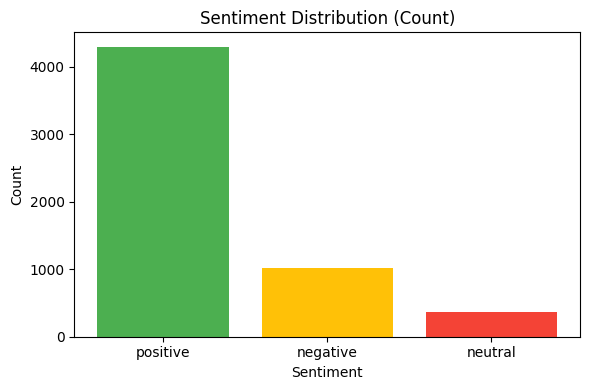

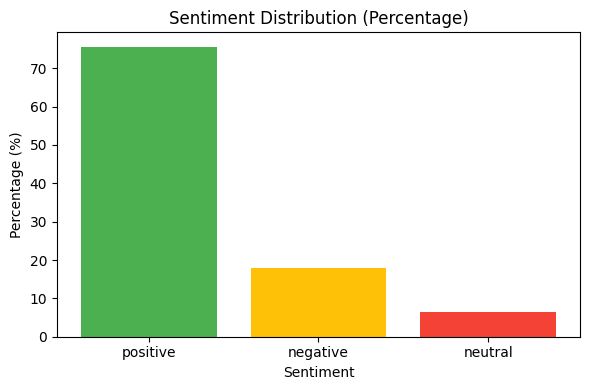

In [54]:
# sentiment quantity breakdown
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
path = r"C:/Users/happy/Documents/ironhack/RoboReview/ai-reviewer/data/hour2_cardiff_sentiment.csv"
df = pd.read_csv(path)

# Calculate counts and percentages
counts = df['sentiment'].value_counts()
percentages = counts / counts.sum()

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'sentiment': counts.index,
    'count': counts.values,
    'percentage': (percentages.values * 100)
})

# Display the summary table
print(summary_df)

# Plot count bar chart
plt.figure(figsize=(6,4))
plt.bar(summary_df['sentiment'], summary_df['count'], color=['#4CAF50','#FFC107','#F44336'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution (Count)')
plt.tight_layout()
plt.show()

# Plot percentage bar chart
plt.figure(figsize=(6,4))
plt.bar(summary_df['sentiment'], summary_df['percentage'], color=['#4CAF50','#FFC107','#F44336'])
plt.xlabel('Sentiment')
plt.ylabel('Percentage (%)')
plt.title('Sentiment Distribution (Percentage)')
plt.tight_layout()
plt.show()


In [55]:
# try LDA
import os
import json
import pandas as pd
import mlflow
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# ————————————————————————————— 0) Load & clean data —————————————————————————————
df = pd.read_csv(
    r"C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\cardiff_sentiment_vehicle_details.csv",
    engine="python", on_bad_lines="skip", sep=","
).dropna(subset=["review"])

# ————————————————————————————— 1) Configure MLflow —————————————————————————————
mlflow.set_experiment("cars-review-topics-lda")
if mlflow.active_run() is not None:
    mlflow.end_run()
with mlflow.start_run(run_name="lda_10_topics"):
    # — Log params —
    n_topics, max_df, min_df = 10, 0.8, 5
    mlflow.log_params({
        "n_topics": n_topics,
        "max_df": max_df,
        "min_df": min_df,
        "learning_method": "online",
        "max_iter": 10
    })

    # — Vectorize —
    vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, stop_words="english")
    X = vectorizer.fit_transform(df["review"].astype(str))

    # — Fit LDA —
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        max_iter=10,
        learning_method="online",
        learning_offset=50.0,
        random_state=42
    )
    lda.fit(X)

    # — Log perplexity —
    mlflow.log_metric("perplexity", lda.perplexity(X))

    # — Compute dominant topic per doc —
    doc_topics = lda.transform(X)
    df["dominant_topic"] = doc_topics.argmax(axis=1)

    # — Build topic → top-words mapping —
    feature_names = vectorizer.get_feature_names_out()
    topic_keywords = {
        topic_idx: [
            feature_names[i] 
            for i in comp.argsort()[:-6:-1]  # top 5 words
        ]
        for topic_idx, comp in enumerate(lda.components_)
    }

    # — Create a column of the joined keywords for each row’s dominant_topic —
    df["topic_keywords"] = df["dominant_topic"].map(
        lambda t: ", ".join(topic_keywords[t])
    )

    # — Persist the keywords dict as an artifact too —
    os.makedirs("lda_artifacts", exist_ok=True)
    with open("lda_artifacts/topic_keywords.json", "w") as f:
        json.dump(topic_keywords, f)
    mlflow.log_artifact("lda_artifacts/topic_keywords.json", artifact_path="topics")

    # — Save & log the augmented DataFrame —
    out_csv = r"C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\reviews_with_topics.csv"
    df.to_csv(out_csv, index=False)
    mlflow.log_artifact(out_csv)

    print("Saved reviews_with_topics.csv with dominant_topic and topic_keywords columns")


🏃 View run intrigued-hog-63 at: http://127.0.0.1:5000/#/experiments/703505664489167421/runs/5ac87eeaa10c4bcb832fd2a0724e69c2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/703505664489167421
Saved reviews_with_topics.csv with dominant_topic and topic_keywords columns
🏃 View run lda_10_topics at: http://127.0.0.1:5000/#/experiments/703505664489167421/runs/4edaa8eff71248618e94f00dbf50330d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/703505664489167421


Check best clustering

cluster

In [71]:
import pandas as pd
import json
import mlflow
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

# 1. Load and preprocess data
df = pd.read_csv(r"C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\reviews_with_topics.csv", engine="python", on_bad_lines="skip", sep=",")
df['review'] = df['review'].fillna('')

# 2. Vectorize review text
max_df = 0.8
min_df = 10
vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df, stop_words='english')
X = vectorizer.fit_transform(df['review'])

# 3. Dimensionality reduction
n_components = 50
svd = TruncatedSVD(n_components=n_components, random_state=42)
X_reduced = svd.fit_transform(X)

# 4. Clustering into six semantic clusters
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X_reduced)
    
# 5. Prepare outputs
preview = df[['make', 'model', 'body_style', 'rating', 'cluster']].head(10)
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
cluster_terms = {
    f"Cluster {i}": [terms[ind] for ind in order_centroids[i, :10]]
    for i in range(n_clusters)
}

# 6. Log everything to MLflow
with mlflow.start_run():
    # Log parameters
    mlflow.log_param("n_clusters", n_clusters)
    mlflow.log_param("n_components", n_components)
    mlflow.log_param("max_df", max_df)
    mlflow.log_param("min_df", min_df)
    mlflow.log_param("vectorizer_stop_words", "english")
    
    # Log model
    mlflow.sklearn.log_model(kmeans, artifact_path="kmeans_model")
    
    # Save and log cluster terms
    with open("cluster_terms.json", "w") as f:
        json.dump(cluster_terms, f, indent=2)
    mlflow.log_artifact("cluster_terms.json")

    # Print outputs
    print("Clustered Review Sample:")
    print(preview.to_string(index=False))
    print("\nTop 10 terms per cluster:")
    for cluster, terms_list in cluster_terms.items():
        print(f"\n{cluster}:")
        print(", ".join(terms_list))

print("\nData preprocessing, clustering, and MLflow logging complete.")


2025/07/04 23:17:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/04 23:17:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Clustered Review Sample:
 make                            model   body_style  rating  cluster
Dodge                 Magnum Wagon SXT    4dr Wagon   4.875        3
Dodge                  Viper Coupe GTS    2dr Coupe   4.750        4
Dodge          Dakota Extended Cab SLT 2dr Extended   4.375        0
Dodge         Ram Pickup 2500 Quad Cab     4dr Quad   5.000        0
Dodge        Grand Caravan Minivan SXT      4dr Ext   2.375        3
Dodge               Caravan Minivan SE  3dr Minivan   4.750        5
Dodge Ram Pickup 2500 Quad Cab Laramie     4dr Quad   4.875        0
Dodge             Challenger Coupe R/T    2dr Coupe   4.875        5
Dodge                Intrepid Sedan ES    4dr Sedan   4.500        2
Dodge     Grand Caravan Minivan SE Fwd  4dr Minivan   4.250        1

Top 10 terms per cluster:

Cluster 0:
02, 00, 04, 08, 10, 09, 10000, 05, 115, 124

Cluster 1:
00, 08, 03, 07, 05, 0l, 1000, 120, 11k, 10k

Cluster 2:
00, 01, 0l, 100, 10000, 03, 06, 110, 100k, 14

Cluster 3:
00, 04,

In [72]:
df

,index,rating,review_date,author_name,vehicle_title,review_title,review,sentiment,sentiment_score,year,make,model,body_style,engine,dominant_topic,topic_keywords,cluster
0,119,4.875,on 04/19/08 20:20 PM (PDT),JJokert1,2007 Dodge Magnum Wagon SXT 4dr Wagon AWD (3.5...,Very Nice Ride!,Great Ride! Fun to drive. I got the SXT with l...,positive,0.908792,2007.0,Dodge,Magnum Wagon SXT,4dr Wagon,3.5L 6cyl 5A,5,"car, great, drive, like, love",3
1,3300,4.750,on 02/24/07 10:52 AM (PST),Kurt,1997 Dodge Viper Coupe GTS 2dr Coupe,Vipers Rule,This is my 2nd Viper. I purchased a 1994 RT/10...,positive,0.842789,1997.0,Dodge,Viper Coupe GTS,2dr Coupe,NaN,5,"car, great, drive, like, love",4
2,4813,4.375,on 08/15/02 00:00 AM (PDT),Autolycus,2000 Dodge Dakota Extended Cab SLT 2dr Extende...,Good Truck,"Extended Cab 4x4, 4. 7L with auto. So far the ...",positive,0.971964,2000.0,Dodge,Dakota Extended Cab SLT,2dr Extended,NaN,5,"car, great, drive, like, love",0
3,2929,5.000,on 12/08/04 16:23 PM (PST),western6,2002 Dodge Ram Pickup 2500 Quad Cab 4dr Quad C...,The Best Truck,"I had a chevy hd with nothing but problems, Th...",positive,0.941065,2002.0,Dodge,Ram Pickup 2500 Quad Cab,4dr Quad,5.9L 8cyl 5M,1,"truck, ram, mpg, dodge, mileage",0
4,6813,2.375,on 09/07/11 05:30 AM (PDT),salyalma,2008 Dodge Grand Caravan Minivan SXT 4dr Ext M...,The woest purchase ever,Not even 50K Miles on it and already expend $1...,negative,0.969424,2008.0,Dodge,Grand Caravan Minivan SXT,4dr Ext,3.8L 6cyl 6A,7,"car, miles, 000, new, bought",3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5680,1682,4.875,on 05/24/15 16:27 PM (PDT),priusdriver101,2005 Volvo XC70 Wagon AWD 4dr Wagon (2.5L 5cyl...,"""They got me """"For Life""""""",I got an excellent deal on this XC70. The ride...,positive,0.790667,2005.0,Volvo,XC70 Wagon AWD,4dr Wagon,2.5L 5cyl Turbo 5A,5,"car, great, drive, like, love",3
5681,3583,3.125,on 12/14/06 12:35 PM (PST),Unhappy,2005 Volvo V50 Wagon T5 AWD 4dr Sport Wagon (2...,Be Careful,I have owned my V50 for 1 1/2 years and I have...,negative,0.922460,2005.0,Volvo,V50 Wagon T5 AWD,4dr Sport,2.5L 5cyl Turbo 6M,7,"car, miles, 000, new, bought",2
5682,714,4.000,on 07/30/07 16:56 PM (PDT),Sunny Blue Skies,2002 Volvo S60 Sedan 2.4 Fwd 4dr Sedan (2.4L 5...,A Nice Upscale Vehicle,I bought my 2002 S60 in 2004. The car already ...,negative,0.640149,2002.0,Volvo,S60 Sedan 2.4 Fwd,4dr Sedan,2.4L 5cyl 5M,7,"car, miles, 000, new, bought",2
5683,540,4.875,on 03/03/08 21:11 PM (PST),James D,2005 Volvo S60 Sedan 2.5T AWD 4dr Sedan (2.5L ...,The One!,This car had me literally standing in the door...,positive,0.973417,2005.0,Volvo,S60 Sedan 2.5T AWD,4dr Sedan,2.5L 5cyl Turbo 5A,5,"car, great, drive, like, love",5


In [ ]:
# save dataset but won't use, dominant topics do not make sense
output_file = r"C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\cardiff_sentiment_vehicle_detailscluster_dominant_topic.csv"
df.to_csv(output_file, index=False)
mlflow.log_artifact(output_file)

In [63]:
df

,index,rating,review_date,author_name,vehicle_title,review_title,review,sentiment,sentiment_score,year,make,model,body_style,engine,dominant_topic,topic_keywords,cluster,cluster_reviews
0,119,4.875,on 04/19/08 20:20 PM (PDT),JJokert1,2007 Dodge Magnum Wagon SXT 4dr Wagon AWD (3.5...,Very Nice Ride!,Great Ride! Fun to drive. I got the SXT with l...,positive,0.908792,2007.0,Dodge,Magnum Wagon SXT,4dr Wagon,3.5L 6cyl 5A,5,"car, great, drive, like, love",3,3
1,3300,4.750,on 02/24/07 10:52 AM (PST),Kurt,1997 Dodge Viper Coupe GTS 2dr Coupe,Vipers Rule,This is my 2nd Viper. I purchased a 1994 RT/10...,positive,0.842789,1997.0,Dodge,Viper Coupe GTS,2dr Coupe,NaN,5,"car, great, drive, like, love",4,4
2,4813,4.375,on 08/15/02 00:00 AM (PDT),Autolycus,2000 Dodge Dakota Extended Cab SLT 2dr Extende...,Good Truck,"Extended Cab 4x4, 4. 7L with auto. So far the ...",positive,0.971964,2000.0,Dodge,Dakota Extended Cab SLT,2dr Extended,NaN,5,"car, great, drive, like, love",0,0
3,2929,5.000,on 12/08/04 16:23 PM (PST),western6,2002 Dodge Ram Pickup 2500 Quad Cab 4dr Quad C...,The Best Truck,"I had a chevy hd with nothing but problems, Th...",positive,0.941065,2002.0,Dodge,Ram Pickup 2500 Quad Cab,4dr Quad,5.9L 8cyl 5M,1,"truck, ram, mpg, dodge, mileage",0,0
4,6813,2.375,on 09/07/11 05:30 AM (PDT),salyalma,2008 Dodge Grand Caravan Minivan SXT 4dr Ext M...,The woest purchase ever,Not even 50K Miles on it and already expend $1...,negative,0.969424,2008.0,Dodge,Grand Caravan Minivan SXT,4dr Ext,3.8L 6cyl 6A,7,"car, miles, 000, new, bought",3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5680,1682,4.875,on 05/24/15 16:27 PM (PDT),priusdriver101,2005 Volvo XC70 Wagon AWD 4dr Wagon (2.5L 5cyl...,"""They got me """"For Life""""""",I got an excellent deal on this XC70. The ride...,positive,0.790667,2005.0,Volvo,XC70 Wagon AWD,4dr Wagon,2.5L 5cyl Turbo 5A,5,"car, great, drive, like, love",3,3
5681,3583,3.125,on 12/14/06 12:35 PM (PST),Unhappy,2005 Volvo V50 Wagon T5 AWD 4dr Sport Wagon (2...,Be Careful,I have owned my V50 for 1 1/2 years and I have...,negative,0.922460,2005.0,Volvo,V50 Wagon T5 AWD,4dr Sport,2.5L 5cyl Turbo 6M,7,"car, miles, 000, new, bought",2,2
5682,714,4.000,on 07/30/07 16:56 PM (PDT),Sunny Blue Skies,2002 Volvo S60 Sedan 2.4 Fwd 4dr Sedan (2.4L 5...,A Nice Upscale Vehicle,I bought my 2002 S60 in 2004. The car already ...,negative,0.640149,2002.0,Volvo,S60 Sedan 2.4 Fwd,4dr Sedan,2.4L 5cyl 5M,7,"car, miles, 000, new, bought",2,2
5683,540,4.875,on 03/03/08 21:11 PM (PST),James D,2005 Volvo S60 Sedan 2.5T AWD 4dr Sedan (2.5L ...,The One!,This car had me literally standing in the door...,positive,0.973417,2005.0,Volvo,S60 Sedan 2.5T AWD,4dr Sedan,2.5L 5cyl Turbo 5A,5,"car, great, drive, like, love",5,5


In [106]:
cardiff

,index,rating,review_date,author_name,vehicle_title,review_title,review,sentiment,sentiment_score,year,make,model,body_style,engine,dominant_topic,topic_keywords,cluster,car_index,car_index2
0,119,4.875,on 04/19/08 20:20 PM (PDT),JJokert1,2007 Dodge Magnum Wagon SXT 4dr Wagon AWD (3.5...,Very Nice Ride!,Great Ride! Fun to drive. I got the SXT with l...,positive,0.908792,2007,Dodge,Magnum Wagon SXT,4dr Wagon,3.5L 6cyl 5A,5,"car, great, drive, like, love",3,dodge_2007,dodge_2007
1,3300,4.750,on 02/24/07 10:52 AM (PST),Kurt,1997 Dodge Viper Coupe GTS 2dr Coupe,Vipers Rule,This is my 2nd Viper. I purchased a 1994 RT/10...,positive,0.842789,1997,Dodge,Viper Coupe GTS,2dr Coupe,NaN,5,"car, great, drive, like, love",4,dodge_1997,dodge_1997
2,4813,4.375,on 08/15/02 00:00 AM (PDT),Autolycus,2000 Dodge Dakota Extended Cab SLT 2dr Extende...,Good Truck,"Extended Cab 4x4, 4. 7L with auto. So far the ...",positive,0.971964,2000,Dodge,Dakota Extended Cab SLT,2dr Extended,NaN,5,"car, great, drive, like, love",0,dodge_2000,dodge_2000
3,2929,5.000,on 12/08/04 16:23 PM (PST),western6,2002 Dodge Ram Pickup 2500 Quad Cab 4dr Quad C...,The Best Truck,"I had a chevy hd with nothing but problems, Th...",positive,0.941065,2002,Dodge,Ram Pickup 2500 Quad Cab,4dr Quad,5.9L 8cyl 5M,1,"truck, ram, mpg, dodge, mileage",0,dodge_2002,dodge_2002
4,6813,2.375,on 09/07/11 05:30 AM (PDT),salyalma,2008 Dodge Grand Caravan Minivan SXT 4dr Ext M...,The woest purchase ever,Not even 50K Miles on it and already expend $1...,negative,0.969424,2008,Dodge,Grand Caravan Minivan SXT,4dr Ext,3.8L 6cyl 6A,7,"car, miles, 000, new, bought",3,dodge_2008,dodge_2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5680,1682,4.875,on 05/24/15 16:27 PM (PDT),priusdriver101,2005 Volvo XC70 Wagon AWD 4dr Wagon (2.5L 5cyl...,"""They got me """"For Life""""""",I got an excellent deal on this XC70. The ride...,positive,0.790667,2005,Volvo,XC70 Wagon AWD,4dr Wagon,2.5L 5cyl Turbo 5A,5,"car, great, drive, like, love",3,volvo_2005,volvo_2005
5681,3583,3.125,on 12/14/06 12:35 PM (PST),Unhappy,2005 Volvo V50 Wagon T5 AWD 4dr Sport Wagon (2...,Be Careful,I have owned my V50 for 1 1/2 years and I have...,negative,0.922460,2005,Volvo,V50 Wagon T5 AWD,4dr Sport,2.5L 5cyl Turbo 6M,7,"car, miles, 000, new, bought",2,volvo_2005,volvo_2005
5682,714,4.000,on 07/30/07 16:56 PM (PDT),Sunny Blue Skies,2002 Volvo S60 Sedan 2.4 Fwd 4dr Sedan (2.4L 5...,A Nice Upscale Vehicle,I bought my 2002 S60 in 2004. The car already ...,negative,0.640149,2002,Volvo,S60 Sedan 2.4 Fwd,4dr Sedan,2.4L 5cyl 5M,7,"car, miles, 000, new, bought",2,volvo_2002,volvo_2002
5683,540,4.875,on 03/03/08 21:11 PM (PST),James D,2005 Volvo S60 Sedan 2.5T AWD 4dr Sedan (2.5L ...,The One!,This car had me literally standing in the door...,positive,0.973417,2005,Volvo,S60 Sedan 2.5T AWD,4dr Sedan,2.5L 5cyl Turbo 5A,5,"car, great, drive, like, love",5,volvo_2005,volvo_2005


In [107]:
experts

,maker,car_model,manufacturing_year,car_full_name,url,strengths,weaknesses,rating,full_description,word_count_for_full_description,...,transmission,length,height,overall_width_with_mirrors,overall_width_without_mirrors,curb_weight,cargo_capacity_all_seats_in_place,model,car_index,car_index2
0,jeep,jeep wrangler,1998,jeep wrangler 1998,https://www.edmunds.com/jeep/wrangler/1998/rev...,"['Unmatched off-road capability, overflowing w...","['Soft top is fun, but still a pain in the $%!...",4.3,Jeep has improved off-road capability by incre...,427,...,5-speed manual,147.7 in.,69.6 in.,NaN,66.7 in.,"3,045 lbs.",11.1 cu.ft.,wrangler,jeep_1998,jeep_1998
1,toyota,toyota 4runner,2005,toyota 4runner 2005,https://www.edmunds.com/toyota/4runner/2005/re...,"['Powerful engine lineup, well mannered on pav...","[""Cargo capacity isn't much more than what man...",4.8,The base V6 now comes with a five-speed automa...,110,...,5-speed automatic,189.0 in.,68.5 in.,NaN,73.8 in.,"4,045 lbs.",36.6 cu.ft.,4runner,toyota_2005,toyota_2005
2,toyota,toyota tundra,2002,toyota tundra 2002,https://www.edmunds.com/toyota/tundra/2002/rev...,"['Silky V8, Toyota build quality, less-than-fu...",['Lacks wide range of choice offered by domest...,4.7,"SR5 models have new 16-inch wheels, and a limi...",534,...,5-speed manual,217.5 in.,70.5 in.,NaN,75.2 in.,"3,795 lbs.",NaN,tundra,toyota_2002,toyota_2002
3,toyota,toyota tacoma,1998,toyota tacoma 1998,https://www.edmunds.com/toyota/tacoma/1998/rev...,"['Unique styling, Toyota reliability, and powe...",['Extended cab models lack a third door and th...,4.6,The 1998 four-wheel-drive Tacomas receive fres...,592,...,5-speed manual,203.1 in.,62.0 in.,NaN,66.5 in.,NaN,NaN,tacoma,toyota_1998,toyota_1998
4,ford,ford ranger,1990,ford ranger 1990,https://www.edmunds.com/ford/ranger/1990/review/,empty,empty,4.1,No changes for the Ford Ranger.,6,...,5-speed manual,188.5 in.,63.6 in.,NaN,66.8 in.,"3,168 lbs.",NaN,ranger,ford_1990,ford_1990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3458,jeep,jeep renegade,2023,jeep renegade 2023,https://www.edmunds.com/jeep/renegade/,"[""Trailhawk model's excellent off-road capabil...",['High price when optioned with nice-to-have f...,NaN,The 2023 Jeep Renegade is a versatile subcomp...,1065,...,9-speed automatic,166.6 in.,66.5 in.,79.6 in.,74.2 in.,"3,210 lbs.",18.5 cu.ft.,renegade,jeep_2023,jeep_2023
3459,bmw,bmw alpina-b7,2022,bmw alpina-b7 2022,https://www.edmunds.com/bmw/alpina-b7/,"['Smooth yet ridiculously quick acceleration',...","['Unintuitive gesture controls', ""Rear seats d...",NaN,High-performance M models have proliferated t...,1210,...,8-speed shiftable automatic,207.4 in.,58.7 in.,85.4 in.,74.9 in.,"4,866 lbs.",18.2 cu.ft.,alpina-b7,bmw_2022,bmw_2022
3460,chevrolet,chevrolet colorado,2022,chevrolet colorado 2022,https://www.edmunds.com/chevrolet/colorado/,['Gasoline V6 and diesel four-cylinder engines...,['Front seats can feel confining for larger pe...,NaN,"After a handful of minor changes last year, t...",1219,...,8-speed shiftable automatic,213.0 in.,78.8 in.,84.4 in.,74.9 in.,"4,270 lbs.",NaN,colorado,chevrolet_2022,chevrolet_2022
3461,bmw,bmw 4-series,2023,bmw 4-series 2023,https://www.edmunds.com/bmw/4-series/2023/m440i/,"['Powerful and fuel-efficient engines', ""Sport...",['Flat hood makes it hard to place the front e...,NaN,The 4 Series is based on the 3 Series sedan b...,1318,...,8-speed shiftable automatic,188.0 in.,54.6 in.,81.9 in.,72.9 in.,"3,858 lbs.",12.0 cu.ft.,4-series,bmw_2023,bmw_2023


In [ ]:
# Enrich data
import pandas as pd

# File paths
experts_path = r"C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\4cars_descriptions_with_details.csv"
cardiff_path = r"C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\cardiff_sentiment_vehicle_details.csv"

# 1. Load datasets
experts = pd.read_csv(experts_path, engine="python", on_bad_lines="skip", sep=",")
cardiff = pd.read_csv(cardiff_path, engine="python", on_bad_lines="skip", sep=",")

# 2. Create 'car_index2' based on maker and year (drop model to broaden match)
experts['car_index2'] = (
    experts['car_brand']
        .str.strip()
        .str.replace(r'\s+', '_', regex=True)
        .str.lower()
    + '_'
    + experts['manufacturing_year'].astype(int).astype(str)
)
cardiff['car_index2'] = (
    cardiff['make']
        .str.strip()
        .str.replace(r'\s+', '_', regex=True)
        .str.lower()
    + '_'
    + cardiff['year'].astype(int).astype(str)
)

# 2b. Deduplicate experts on 'car_index2' to prevent many-to-many merges
experts_unique = experts.drop_duplicates(subset=['car_index2'])

# 3. Merge on exact 'car_index2'
merged = cardiff.merge(
    experts_unique[['car_index2', 'strengths', 'weaknesses']],
    on='car_index2',
    how='left'
)

# 4. Compute match statistics
total_reviews = len(cardiff)
matched_reviews = merged['strengths'].notna().sum()
match_rate = matched_reviews / total_reviews * 100

print(f"Total reviews: {total_reviews}")
print(f"Merged reviews: {matched_reviews} ({match_rate:.1f}%)")

# 5. Preview some merged entries (showing car_index2)
print("\nSample merged rows:")
print(merged[['car_index2', 'strengths', 'weaknesses']].head(10).to_string(index=False))


Total reviews: 5685
Merged reviews: 1545 (27.2%)

Sample merged rows:
car_index2                                                                                                                                      strengths                                                                                                                  weaknesses
dodge_2007                                   ['Powerful V8 engines, smooth ride quality, off-road competence, ample cargo capacity, intuitive controls.']                                     ['Disappointing mileage, poor fit and finish, cramped second-row legroom and storage.']
dodge_1997                                                                                                                                            NaN                                                                                                                         NaN
dodge_2000                                                                                 ['Agg

In [120]:
experts.shape

(3463, 27)

In [121]:
cardiff.shape

(5685, 19)

In [130]:
merged.shape

(5685, 21)

In [131]:
merged

,index,rating,review_date,author_name,vehicle_title,review_title,review,sentiment,sentiment_score,year,...,model,body_style,engine,dominant_topic,topic_keywords,cluster,car_index,car_index2,strengths,weaknesses
0,119,4.875,on 04/19/08 20:20 PM (PDT),JJokert1,2007 Dodge Magnum Wagon SXT 4dr Wagon AWD (3.5...,Very Nice Ride!,Great Ride! Fun to drive. I got the SXT with l...,positive,0.908792,2007,...,Magnum Wagon SXT,4dr Wagon,3.5L 6cyl 5A,5,"car, great, drive, like, love",3,dodge_2007,dodge_2007,"['Powerful V8 engines, smooth ride quality, of...","['Disappointing mileage, poor fit and finish, ..."
1,3300,4.750,on 02/24/07 10:52 AM (PST),Kurt,1997 Dodge Viper Coupe GTS 2dr Coupe,Vipers Rule,This is my 2nd Viper. I purchased a 1994 RT/10...,positive,0.842789,1997,...,Viper Coupe GTS,2dr Coupe,NaN,5,"car, great, drive, like, love",4,dodge_1997,dodge_1997,NaN,NaN
2,4813,4.375,on 08/15/02 00:00 AM (PDT),Autolycus,2000 Dodge Dakota Extended Cab SLT 2dr Extende...,Good Truck,"Extended Cab 4x4, 4. 7L with auto. So far the ...",positive,0.971964,2000,...,Dakota Extended Cab SLT,2dr Extended,NaN,5,"car, great, drive, like, love",0,dodge_2000,dodge_2000,"['Aggressive styling, large interior, powerful...","[""5.2-liter V8's power disappointing, interior..."
3,2929,5.000,on 12/08/04 16:23 PM (PST),western6,2002 Dodge Ram Pickup 2500 Quad Cab 4dr Quad C...,The Best Truck,"I had a chevy hd with nothing but problems, Th...",positive,0.941065,2002,...,Ram Pickup 2500 Quad Cab,4dr Quad,5.9L 8cyl 5M,1,"truck, ram, mpg, dodge, mileage",0,dodge_2002,dodge_2002,"['Commodious cabin, newly optional side-curtai...","['Some cheap interior trim, high fuel consumpt..."
4,6813,2.375,on 09/07/11 05:30 AM (PDT),salyalma,2008 Dodge Grand Caravan Minivan SXT 4dr Ext M...,The woest purchase ever,Not even 50K Miles on it and already expend $1...,negative,0.969424,2008,...,Grand Caravan Minivan SXT,4dr Ext,3.8L 6cyl 6A,7,"car, miles, 000, new, bought",3,dodge_2008,dodge_2008,"['Powerful V8 engines, smooth ride, respectabl...","['Poor fuel mileage, subpar fit and finish ins..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5680,1682,4.875,on 05/24/15 16:27 PM (PDT),priusdriver101,2005 Volvo XC70 Wagon AWD 4dr Wagon (2.5L 5cyl...,"""They got me """"For Life""""""",I got an excellent deal on this XC70. The ride...,positive,0.790667,2005,...,XC70 Wagon AWD,4dr Wagon,2.5L 5cyl Turbo 5A,5,"car, great, drive, like, love",3,volvo_2005,volvo_2005,NaN,NaN
5681,3583,3.125,on 12/14/06 12:35 PM (PST),Unhappy,2005 Volvo V50 Wagon T5 AWD 4dr Sport Wagon (2...,Be Careful,I have owned my V50 for 1 1/2 years and I have...,negative,0.922460,2005,...,V50 Wagon T5 AWD,4dr Sport,2.5L 5cyl Turbo 6M,7,"car, miles, 000, new, bought",2,volvo_2005,volvo_2005,NaN,NaN
5682,714,4.000,on 07/30/07 16:56 PM (PDT),Sunny Blue Skies,2002 Volvo S60 Sedan 2.4 Fwd 4dr Sedan (2.4L 5...,A Nice Upscale Vehicle,I bought my 2002 S60 in 2004. The car already ...,negative,0.640149,2002,...,S60 Sedan 2.4 Fwd,4dr Sedan,2.4L 5cyl 5M,7,"car, miles, 000, new, bought",2,volvo_2002,volvo_2002,NaN,NaN
5683,540,4.875,on 03/03/08 21:11 PM (PST),James D,2005 Volvo S60 Sedan 2.5T AWD 4dr Sedan (2.5L ...,The One!,This car had me literally standing in the door...,positive,0.973417,2005,...,S60 Sedan 2.5T AWD,4dr Sedan,2.5L 5cyl Turbo 5A,5,"car, great, drive, like, love",5,volvo_2005,volvo_2005,NaN,NaN


In [64]:
output_file = r"C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\cardiff_experts_merged.csv"
merged.to_csv(output_file, index=False)
mlflow.log_artifact(output_file)

In [115]:
merged

,index,rating,review_date,author_name,vehicle_title,review_title,review,sentiment,sentiment_score,year,...,model,body_style,engine,dominant_topic,topic_keywords,cluster,car_index,car_index2,strengths,weaknesses
0,119,4.875,on 04/19/08 20:20 PM (PDT),JJokert1,2007 Dodge Magnum Wagon SXT 4dr Wagon AWD (3.5...,Very Nice Ride!,Great Ride! Fun to drive. I got the SXT with l...,positive,0.908792,2007,...,Magnum Wagon SXT,4dr Wagon,3.5L 6cyl 5A,5,"car, great, drive, like, love",3,dodge_2007,dodge_2007,"['Powerful V8 engines, smooth ride quality, of...","['Disappointing mileage, poor fit and finish, ..."
1,119,4.875,on 04/19/08 20:20 PM (PDT),JJokert1,2007 Dodge Magnum Wagon SXT 4dr Wagon AWD (3.5...,Very Nice Ride!,Great Ride! Fun to drive. I got the SXT with l...,positive,0.908792,2007,...,Magnum Wagon SXT,4dr Wagon,3.5L 6cyl 5A,5,"car, great, drive, like, love",3,dodge_2007,dodge_2007,['Sports car performance with sedan functional...,"['Heavy curb weight, some low-grade interior p..."
2,3300,4.750,on 02/24/07 10:52 AM (PST),Kurt,1997 Dodge Viper Coupe GTS 2dr Coupe,Vipers Rule,This is my 2nd Viper. I purchased a 1994 RT/10...,positive,0.842789,1997,...,Viper Coupe GTS,2dr Coupe,NaN,5,"car, great, drive, like, love",4,dodge_1997,dodge_1997,NaN,NaN
3,4813,4.375,on 08/15/02 00:00 AM (PDT),Autolycus,2000 Dodge Dakota Extended Cab SLT 2dr Extende...,Good Truck,"Extended Cab 4x4, 4. 7L with auto. So far the ...",positive,0.971964,2000,...,Dakota Extended Cab SLT,2dr Extended,NaN,5,"car, great, drive, like, love",0,dodge_2000,dodge_2000,"['Aggressive styling, large interior, powerful...","[""5.2-liter V8's power disappointing, interior..."
4,2929,5.000,on 12/08/04 16:23 PM (PST),western6,2002 Dodge Ram Pickup 2500 Quad Cab 4dr Quad C...,The Best Truck,"I had a chevy hd with nothing but problems, Th...",positive,0.941065,2002,...,Ram Pickup 2500 Quad Cab,4dr Quad,5.9L 8cyl 5M,1,"truck, ram, mpg, dodge, mileage",0,dodge_2002,dodge_2002,"['Commodious cabin, newly optional side-curtai...","['Some cheap interior trim, high fuel consumpt..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10514,1682,4.875,on 05/24/15 16:27 PM (PDT),priusdriver101,2005 Volvo XC70 Wagon AWD 4dr Wagon (2.5L 5cyl...,"""They got me """"For Life""""""",I got an excellent deal on this XC70. The ride...,positive,0.790667,2005,...,XC70 Wagon AWD,4dr Wagon,2.5L 5cyl Turbo 5A,5,"car, great, drive, like, love",3,volvo_2005,volvo_2005,NaN,NaN
10515,3583,3.125,on 12/14/06 12:35 PM (PST),Unhappy,2005 Volvo V50 Wagon T5 AWD 4dr Sport Wagon (2...,Be Careful,I have owned my V50 for 1 1/2 years and I have...,negative,0.922460,2005,...,V50 Wagon T5 AWD,4dr Sport,2.5L 5cyl Turbo 6M,7,"car, miles, 000, new, bought",2,volvo_2005,volvo_2005,NaN,NaN
10516,714,4.000,on 07/30/07 16:56 PM (PDT),Sunny Blue Skies,2002 Volvo S60 Sedan 2.4 Fwd 4dr Sedan (2.4L 5...,A Nice Upscale Vehicle,I bought my 2002 S60 in 2004. The car already ...,negative,0.640149,2002,...,S60 Sedan 2.4 Fwd,4dr Sedan,2.4L 5cyl 5M,7,"car, miles, 000, new, bought",2,volvo_2002,volvo_2002,NaN,NaN
10517,540,4.875,on 03/03/08 21:11 PM (PST),James D,2005 Volvo S60 Sedan 2.5T AWD 4dr Sedan (2.5L ...,The One!,This car had me literally standing in the door...,positive,0.973417,2005,...,S60 Sedan 2.5T AWD,4dr Sedan,2.5L 5cyl Turbo 5A,5,"car, great, drive, like, love",5,volvo_2005,volvo_2005,NaN,NaN


In [76]:
# assign topics
import pandas as pd
import re

# 1. Load your merged dataset (adjust path if needed)
# This file should contain columns: review_title, review, strengths, weaknesses
merged = pd.read_csv( r"C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\cardiff_experts_merged.csv", engine="python", on_bad_lines="skip", sep=",")   

# 2. Combine text columns into one
text_cols = ['review_title', 'review', 'strengths', 'weaknesses']
merged['combined_text'] = merged[text_cols].fillna('').agg(' '.join, axis=1)

# 3. Define target topics and associated keyword lists
topics = {
    'value_for_money':    ['price', 'cost', 'value', 'expensive', 'cheap', 'affordable', 'worth', 'budget'],
    'size':               ['size', 'small', 'large', 'compact', 'space', 'roomy', 'tight', 'dimensions'],
    'reliability':        ['reliable', 'reliability', 'breakdown', 'durable', 'maintenance', 'repair'],
    'sustainability':     ['eco', 'efficient', 'hybrid', 'electric', 'emission', 'green', 'fuel economy'],
    'speed':              ['speed', 'fast', 'acceleration', '0-60', 'mph', 'quick'],
    'luxury':             ['luxury', 'premium', 'upscale', 'leather', 'chrome', 'elegant'],
    'comfort':            ['comfort', 'comfortable', 'ride quality', 'smooth', 'seat', 'cabin']
}

# 4. Function to assign a topic based on keyword counts
def assign_topic(text):
    text_low = text.lower()
    scores = {topic: sum(text_low.count(kw) for kw in kws) for topic, kws in topics.items()}
    best_topic, best_score = max(scores.items(), key=lambda kv: kv[1])
    return best_topic if best_score > 0 else 'other'

# 5. Apply topic assignment
merged['assigned_topic'] = merged['combined_text'].apply(assign_topic)

# 6. Inspect distribution of assigned topics
topic_counts = merged['assigned_topic'].value_counts()
print("Topic distribution:")
print(topic_counts)

# 7. Preview a few rows
print("\nSample rows with assigned topics:")
print(merged[['review_title','assigned_topic']].head(10).to_string(index=False))

# 8. Save results if desired
# merged.to_csv(r"C:\path\to\merged_with_topics.csv", index=False)


Topic distribution:
assigned_topic
comfort            1284
value_for_money    1141
other               781
size                705
speed               601
sustainability      530
reliability         461
luxury              182
Name: count, dtype: int64

Sample rows with assigned topics:
                         review_title  assigned_topic
                      Very Nice Ride!            size
                          Vipers Rule value_for_money
                           Good Truck         comfort
                       The Best Truck value_for_money
              The woest purchase ever  sustainability
                             Reliable     reliability
                         5. 9 Cummuns           speed
                         What a ride!         comfort
Watch out for power steering problems value_for_money
                          Recommended  sustainability


In [79]:
merged

,index,rating,review_date,author_name,vehicle_title,review_title,review,sentiment,sentiment_score,year,make,model,body_style,engine,car_index,car_index2,strengths,weaknesses,combined_text,assigned_topic
0,119,4.875,on 04/19/08 20:20 PM (PDT),JJokert1,2007 Dodge Magnum Wagon SXT 4dr Wagon AWD (3.5...,Very Nice Ride!,Great Ride! Fun to drive. I got the SXT with l...,positive,0.908792,2007,Dodge,Magnum Wagon SXT,4dr Wagon,3.5L 6cyl 5A,dodge_2007,dodge_2007,"['Powerful V8 engines, smooth ride quality, of...","['Disappointing mileage, poor fit and finish, ...",Very Nice Ride! Great Ride! Fun to drive. I go...,size
1,3300,4.750,on 02/24/07 10:52 AM (PST),Kurt,1997 Dodge Viper Coupe GTS 2dr Coupe,Vipers Rule,This is my 2nd Viper. I purchased a 1994 RT/10...,positive,0.842789,1997,Dodge,Viper Coupe GTS,2dr Coupe,NaN,dodge_1997,dodge_1997,NaN,NaN,Vipers Rule This is my 2nd Viper. I purchased ...,value_for_money
2,4813,4.375,on 08/15/02 00:00 AM (PDT),Autolycus,2000 Dodge Dakota Extended Cab SLT 2dr Extende...,Good Truck,"Extended Cab 4x4, 4. 7L with auto. So far the ...",positive,0.971964,2000,Dodge,Dakota Extended Cab SLT,2dr Extended,NaN,dodge_2000,dodge_2000,"['Aggressive styling, large interior, powerful...","[""5.2-liter V8's power disappointing, interior...","Good Truck Extended Cab 4x4, 4. 7L with auto. ...",comfort
3,2929,5.000,on 12/08/04 16:23 PM (PST),western6,2002 Dodge Ram Pickup 2500 Quad Cab 4dr Quad C...,The Best Truck,"I had a chevy hd with nothing but problems, Th...",positive,0.941065,2002,Dodge,Ram Pickup 2500 Quad Cab,4dr Quad,5.9L 8cyl 5M,dodge_2002,dodge_2002,"['Commodious cabin, newly optional side-curtai...","['Some cheap interior trim, high fuel consumpt...",The Best Truck I had a chevy hd with nothing b...,value_for_money
4,6813,2.375,on 09/07/11 05:30 AM (PDT),salyalma,2008 Dodge Grand Caravan Minivan SXT 4dr Ext M...,The woest purchase ever,Not even 50K Miles on it and already expend $1...,negative,0.969424,2008,Dodge,Grand Caravan Minivan SXT,4dr Ext,3.8L 6cyl 6A,dodge_2008,dodge_2008,"['Powerful V8 engines, smooth ride, respectabl...","['Poor fuel mileage, subpar fit and finish ins...",The woest purchase ever Not even 50K Miles on ...,sustainability
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5680,1682,4.875,on 05/24/15 16:27 PM (PDT),priusdriver101,2005 Volvo XC70 Wagon AWD 4dr Wagon (2.5L 5cyl...,"""They got me """"For Life""""""",I got an excellent deal on this XC70. The ride...,positive,0.790667,2005,Volvo,XC70 Wagon AWD,4dr Wagon,2.5L 5cyl Turbo 5A,volvo_2005,volvo_2005,NaN,NaN,"""They got me """"For Life"""""" I got an excellent ...",comfort
5681,3583,3.125,on 12/14/06 12:35 PM (PST),Unhappy,2005 Volvo V50 Wagon T5 AWD 4dr Sport Wagon (2...,Be Careful,I have owned my V50 for 1 1/2 years and I have...,negative,0.922460,2005,Volvo,V50 Wagon T5 AWD,4dr Sport,2.5L 5cyl Turbo 6M,volvo_2005,volvo_2005,NaN,NaN,Be Careful I have owned my V50 for 1 1/2 years...,reliability
5682,714,4.000,on 07/30/07 16:56 PM (PDT),Sunny Blue Skies,2002 Volvo S60 Sedan 2.4 Fwd 4dr Sedan (2.4L 5...,A Nice Upscale Vehicle,I bought my 2002 S60 in 2004. The car already ...,negative,0.640149,2002,Volvo,S60 Sedan 2.4 Fwd,4dr Sedan,2.4L 5cyl 5M,volvo_2002,volvo_2002,NaN,NaN,A Nice Upscale Vehicle I bought my 2002 S60 in...,reliability
5683,540,4.875,on 03/03/08 21:11 PM (PST),James D,2005 Volvo S60 Sedan 2.5T AWD 4dr Sedan (2.5L ...,The One!,This car had me literally standing in the door...,positive,0.973417,2005,Volvo,S60 Sedan 2.5T AWD,4dr Sedan,2.5L 5cyl Turbo 5A,volvo_2005,volvo_2005,NaN,NaN,The One! This car had me literally standing in...,comfort


In [80]:
output_file = r"C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\enriched_dataset.csv"
merged.to_csv(output_file, index=False)
mlflow.log_artifact(output_file)

In [ ]:
# Count how many reviews of each assigned_topic for every (make, model).
# Pivots to one row per (make,model) with one column per topic.
# Run a small K-Means on those topic-counts (with k=7) to force exactly seven groups.
import pandas as pd
from sklearn.cluster import KMeans

# 1) Load your enriched dataset
df = pd.read_csv(r"C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\enriched_dataset.csv")

# 2) How many assigned_topics do we actually have?
print("Unique topics:", df['assigned_topic'].unique())
print(df['assigned_topic'].value_counts())

# 3) Build counts of each topic within each make / model
grouped = (
    df
    .groupby(['make','model','assigned_topic'])
    .size()
    .reset_index(name='count')
)

# 4) Pivot so that each row is one (make,model) and columns are topic counts
pivot = (
    grouped
    .pivot_table(
        index=['make','model'],
        columns='assigned_topic',
        values='count',
        fill_value=0
    )
)

# 5) Save this raw counts table
pivot.to_csv("make_model_topic_counts.csv")
print("→ Saved topic counts by make/model to make_model_topic_counts.csv")

# 6) (Optional) If you *do* want to reduce these into 7 clusters:
X = pivot.values
kmeans = KMeans(n_clusters=7, random_state=42)
pivot['cluster_simple'] = kmeans.fit_predict(X)

# 7) Persist the simple clusters
pivot.reset_index().to_csv(r"C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\make_model_topic_clusters_simple.csv", index=False)
print("→ Saved simple 7-cluster assignments to make_model_topic_clusters_simple.csv")


Unique topics: ['size' 'value_for_money' 'comfort' 'sustainability' 'reliability' 'speed'
 'other' 'luxury']
assigned_topic
comfort            1284
value_for_money    1141
other               781
size                705
speed               601
sustainability      530
reliability         461
luxury              182
Name: count, dtype: int64
→ Saved topic counts by make/model to make_model_topic_counts.csv
→ Saved simple 7-cluster assignments to make_model_topic_clusters_simple.csv


In [82]:
# clustering
# a bit better better clustering... and it so seems
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# optional MLflow
try:
    import mlflow, mlflow.sklearn
    from mlflow.models.signature import infer_signature
    mlflow_available = True
except ImportError:
    mlflow_available = False
    print("MLflow not installed: skipping logging.")

# 1) load
df = pd.read_csv(
    r"C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\enriched_dataset.csv"
)

# 2) combine text fields, including 'assigned_topic'
df["text_for_clustering"] = (
    df["review"].fillna("") + "  " +
    df["strengths"].fillna("") + "  " +
    df["weaknesses"].fillna("") + "  " +
    df["assigned_topic"].fillna("").astype(str)
)

# 3) TF–IDF
tfidf = TfidfVectorizer(
    max_features=10_000,
    stop_words="english",
    ngram_range=(1,2)
)
X_tfidf = tfidf.fit_transform(df["text_for_clustering"])

# 4) LDA topic modeling instead of SVD
lda = LatentDirichletAllocation(
    n_components=7,
    random_state=42
)
doc_topics = lda.fit_transform(X_tfidf)
X_reduced = doc_topics  # now shape = (n_samples, 7)

# 5) silhouette search over k=4…8
sil_scores = {}
for k in range(4, 9):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_reduced)
    sil_scores[k] = silhouette_score(X_reduced, labels)

best_k = max(sil_scores, key=sil_scores.get)
print(f"Silhouette scores: {sil_scores}")
print(f"→ best_k = {best_k}")

# save silhouette plot
os.makedirs("plots", exist_ok=True)
plt.figure(figsize=(6,4))
plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker="o")
plt.xlabel("n_clusters (k)")
plt.ylabel("Silhouette score")
plt.title("Silhouette Curve (LDA space)")
plt.tight_layout()
sil_plot = "plots/silhouette_vs_k.png"
plt.savefig(sil_plot)
plt.close()

# 6) final clustering
km_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df["cluster"] = km_final.fit_predict(X_reduced)

# 7) 2D PCA plot
pca2 = PCA(n_components=2, random_state=42)
X2D = pca2.fit_transform(X_reduced)
plt.figure(figsize=(6,6))
plt.scatter(X2D[:,0], X2D[:,1], c=df["cluster"], cmap="tab10", s=15)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title(f"KMeans k={best_k} (2D PCA on LDA topics)")
plt.tight_layout()
plot2d = "plots/cluster_2d.png"
plt.savefig(plot2d)
plt.close()

# 8) 3D PCA plot
pca3 = PCA(n_components=3, random_state=42)
X3D = pca3.fit_transform(X_reduced)
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    X3D[:,0], X3D[:,1], X3D[:,2],
    c=df["cluster"], cmap="tab10", s=20
)
ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
ax.set_title(f"KMeans k={best_k} (3D PCA on LDA topics)")
plt.tight_layout()
plot3d = "plots/cluster_3d.png"
fig.savefig(plot3d)
plt.close()

# 9) top-3 per cluster by rating & sentiment_score
df_sorted = df.sort_values(
    by=["cluster","rating","sentiment_score"],
    ascending=[True, False, False]
)
top3 = df_sorted.groupby("cluster").head(3).reset_index(drop=True)

# 10) save CSVs
out_full = r"C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\enriched_with_clusters5.csv"
out_top3 = r"C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\top3_by_cluster5.csv"
df.to_csv(out_full, index=False)
top3.to_csv(out_top3, index=False)
print("Saved:", out_full, "and", out_top3)

# 11) MLflow logging
if mlflow_available:
    # if there’s already a run open, close it
    if mlflow.active_run() is not None:
        mlflow.end_run()
        with mlflow.start_run():
            # params
            mlflow.log_param("best_k", best_k)
            mlflow.log_param("text_fields", "review+strengths+weaknesses+assigned_topic")
            mlflow.log_param("embedding", "LDA (7 topics)")
            # silhouette metrics
            for k, sc in sil_scores.items():
                mlflow.log_metric(f"silhouette_{k}", sc)
            # artifacts
            mlflow.log_artifact(sil_plot)
            mlflow.log_artifact(plot2d)
            mlflow.log_artifact(plot3d)
            mlflow.log_artifact(out_full)
            mlflow.log_artifact(out_top3)
            # model
            # infer signature so MLflow knows input schema
            signature = infer_signature(X_reduced[:5], km_final.predict(X_reduced[:5]))
            mlflow.sklearn.log_model(
                km_final,
                name="kmeans_model",
                signature=signature,
                input_example=X_reduced[:5]
            )
            print("Logged everything to MLflow.")


Silhouette scores: {4: 0.5673299687910527, 5: 0.5889254067572187, 6: 0.5973429751471295, 7: 0.6159134285309528, 8: 0.5922231932555061}
→ best_k = 7
Saved: C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\enriched_with_clusters5.csv and C:\Users\happy\Documents\ironhack\RoboReview\ai-reviewer\data\top3_by_cluster5.csv
🏃 View run able-fowl-595 at: http://127.0.0.1:5000/#/experiments/703505664489167421/runs/8eaae0226b104d62817d5fce1a525779
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/703505664489167421


2025/07/04 23:35:48 INFO mlflow.models.model: Found the following environment variables used during model inference: [OPENAI_API_KEY]. Please check if you need to set them when deploying the model. To disable this message, set environment variable `MLFLOW_RECORD_ENV_VARS_IN_MODEL_LOGGING` to `false`.


Logged everything to MLflow.
🏃 View run grandiose-owl-50 at: http://127.0.0.1:5000/#/experiments/703505664489167421/runs/65bc9cf78cd443e0b8f8a4758675cf7b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/703505664489167421


2025/07/04 23:39:00 INFO mlflow.tracking.fluent: Experiment with name 'cluster_sentiment_analysis' does not exist. Creating a new experiment.


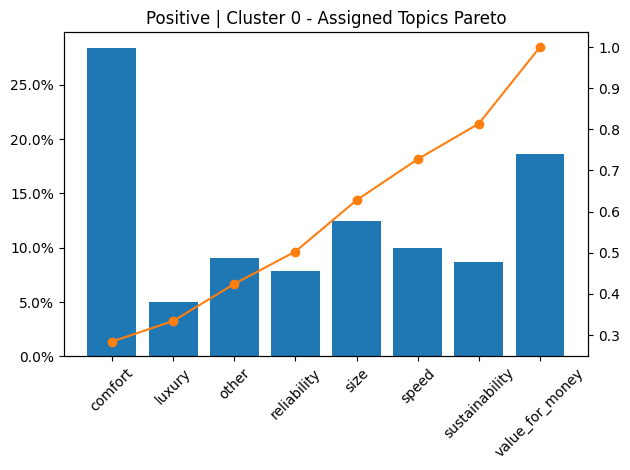

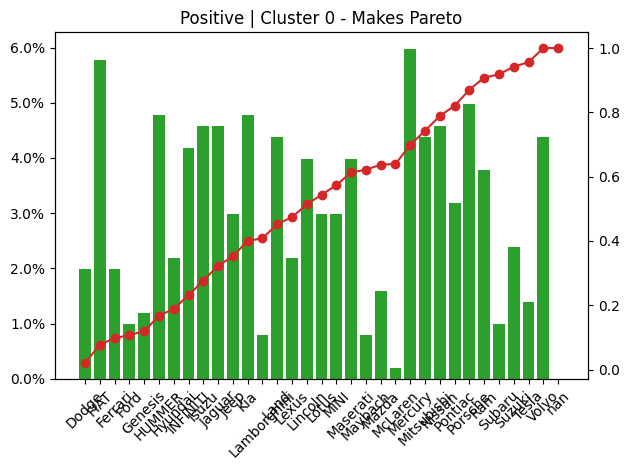

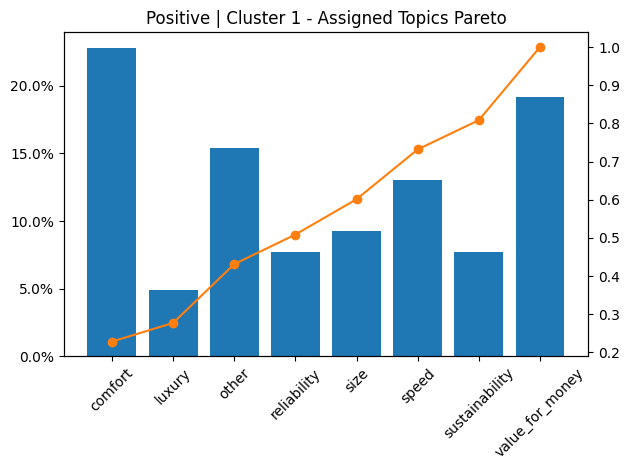

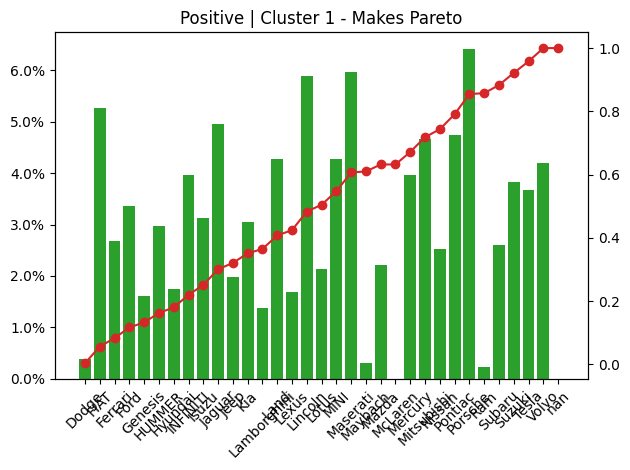

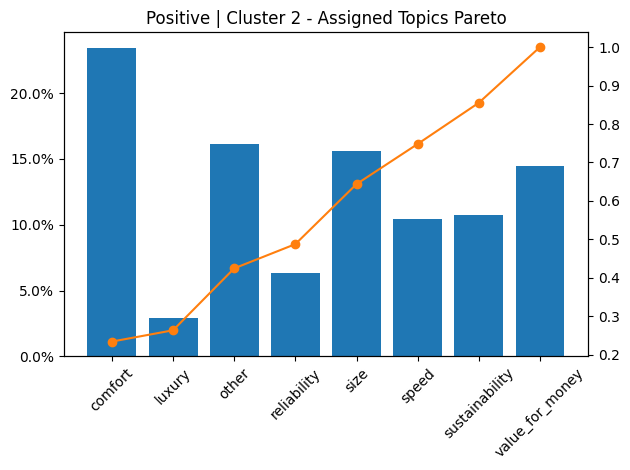

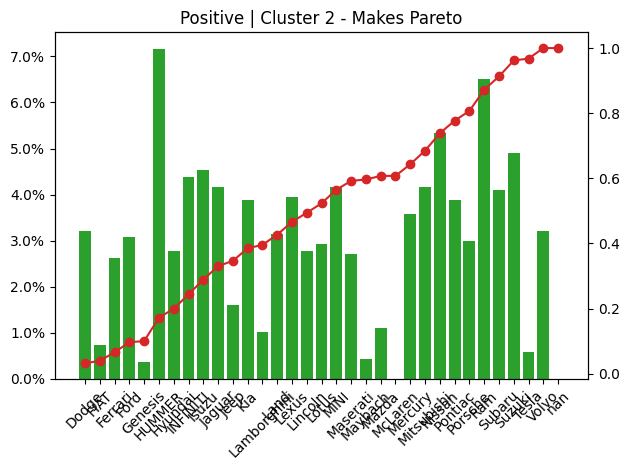

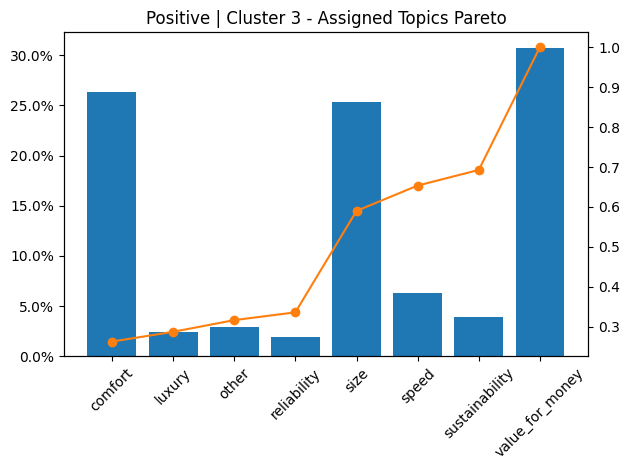

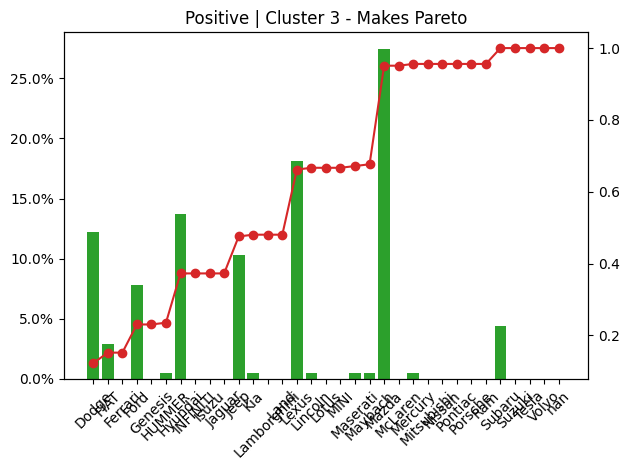

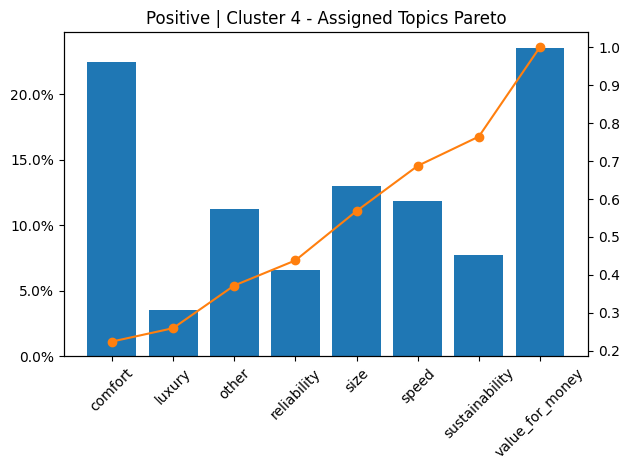

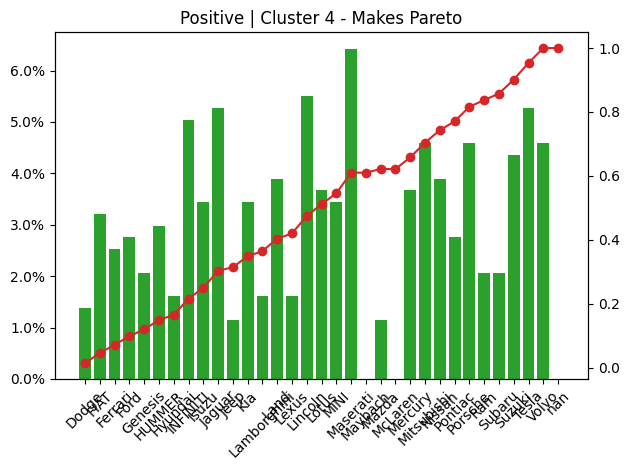

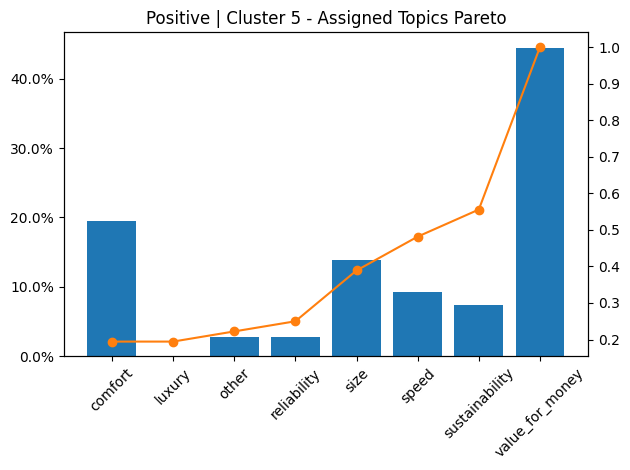

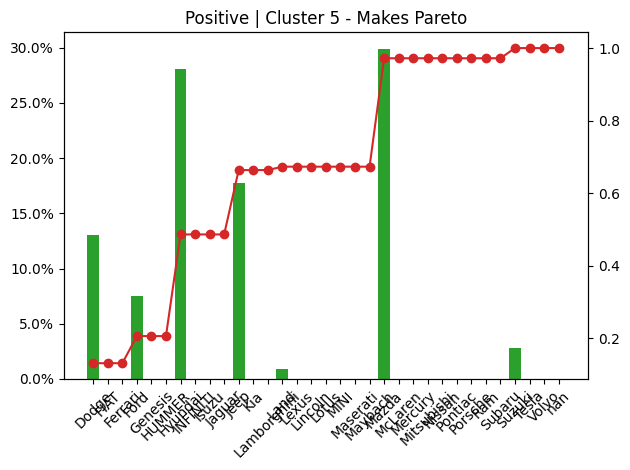

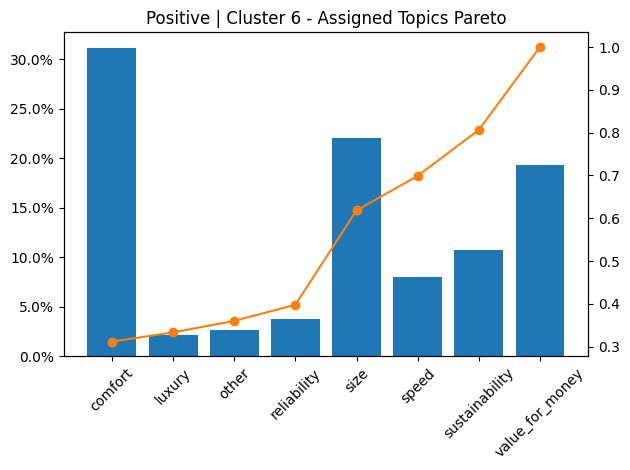

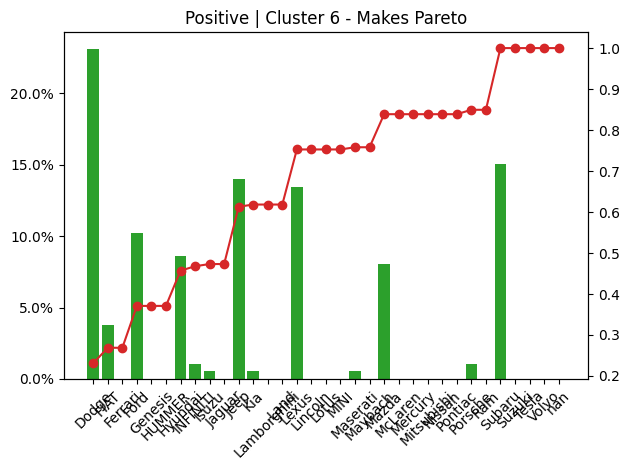

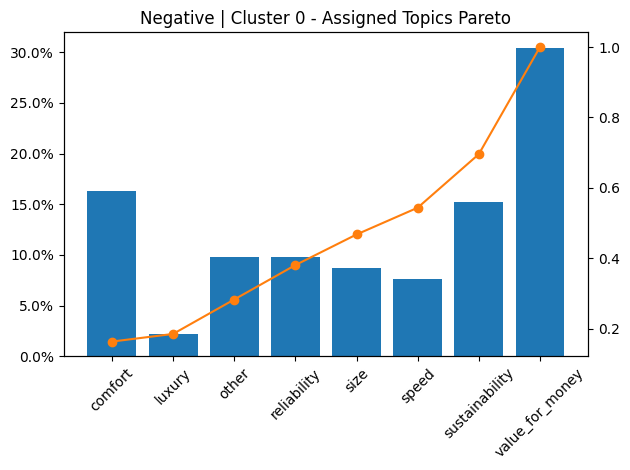

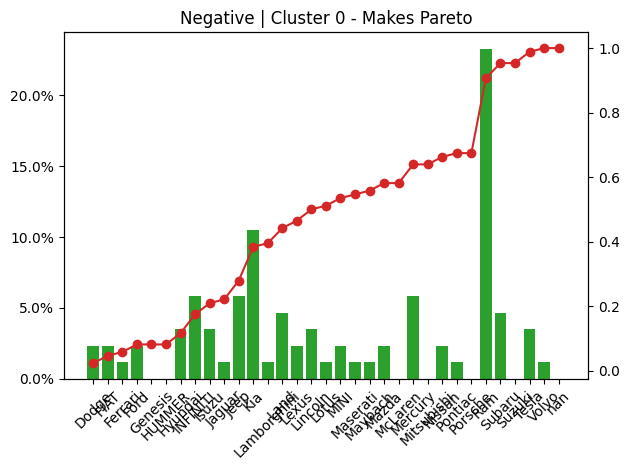

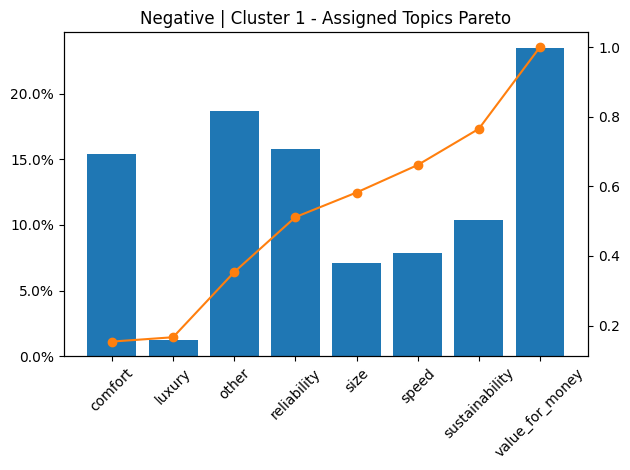

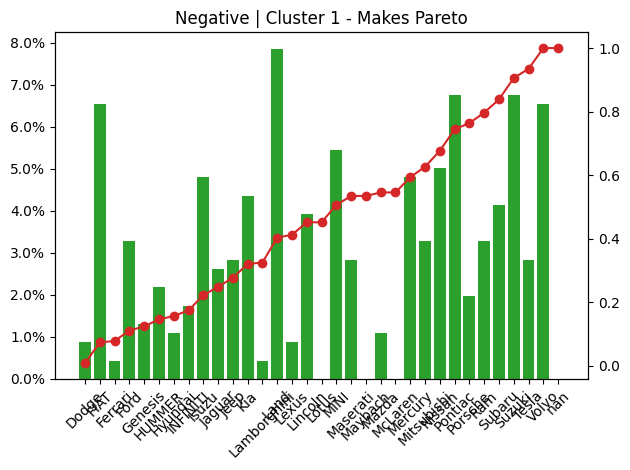

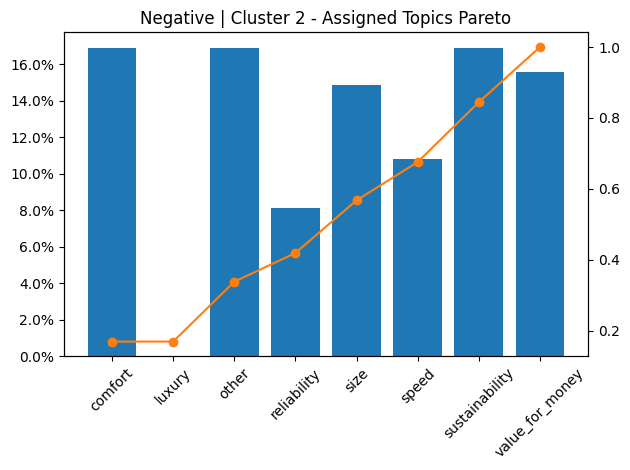

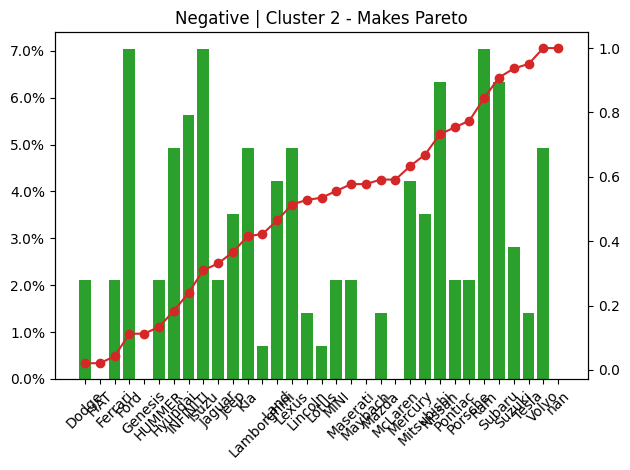

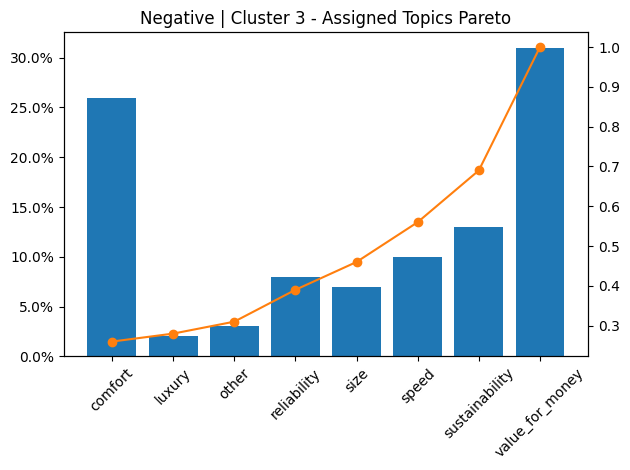

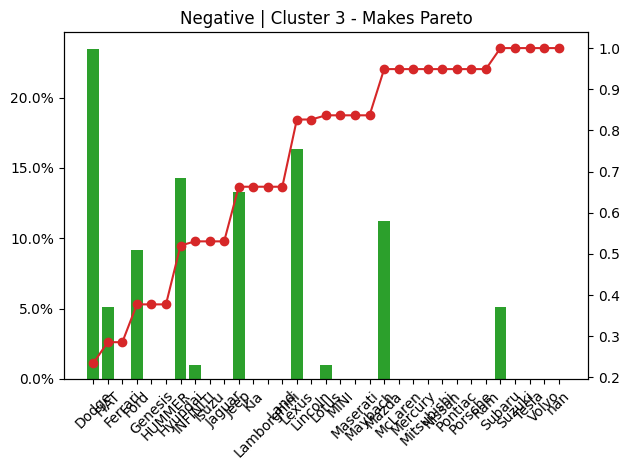

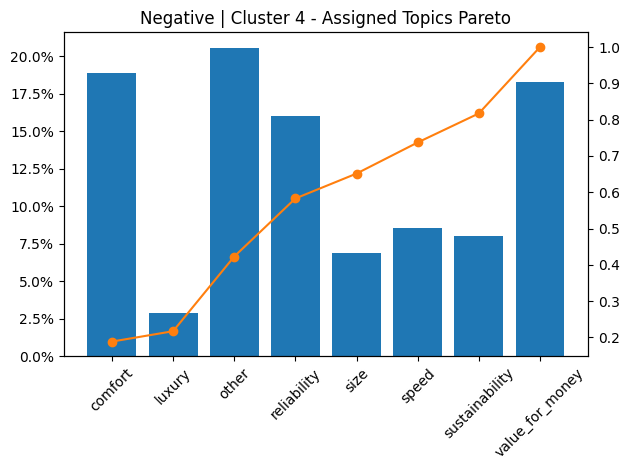

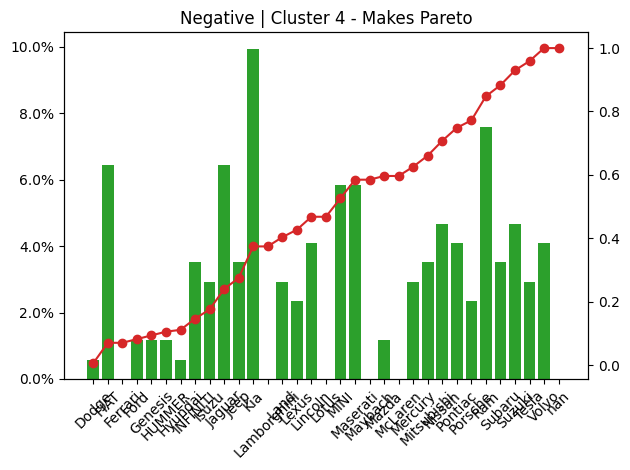

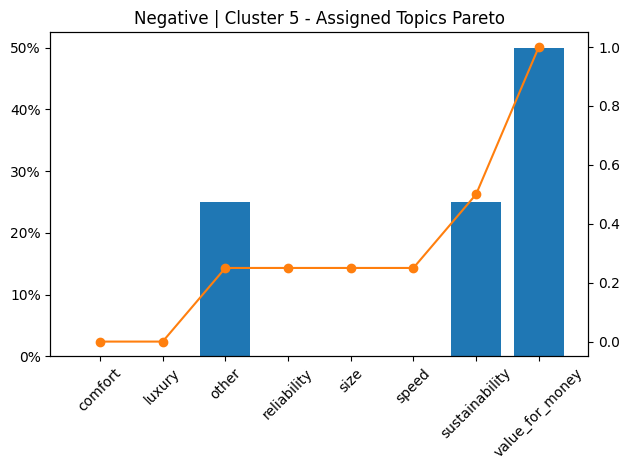

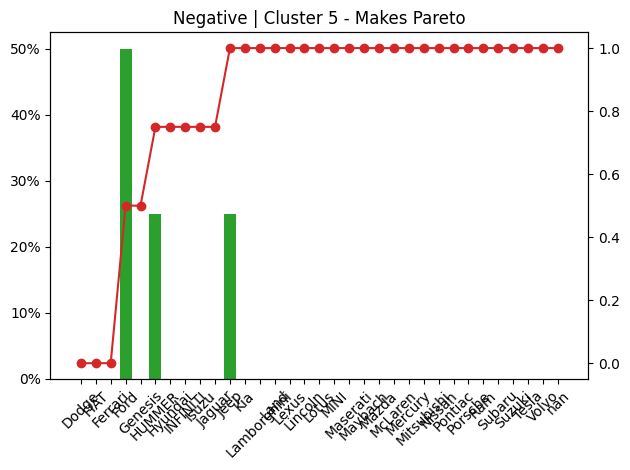

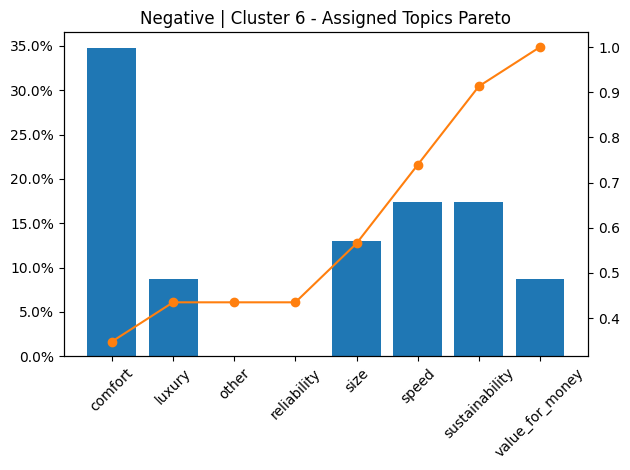

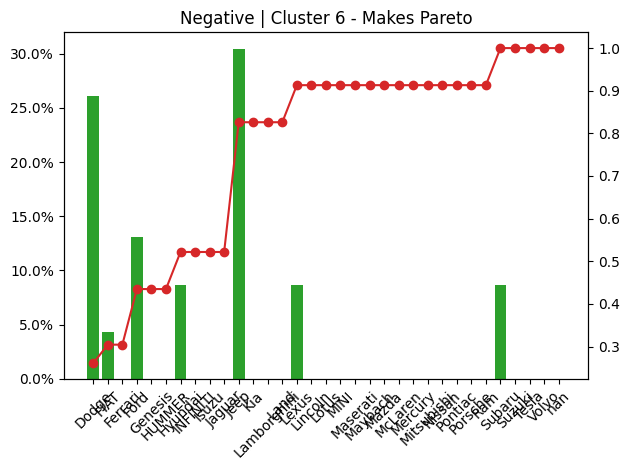

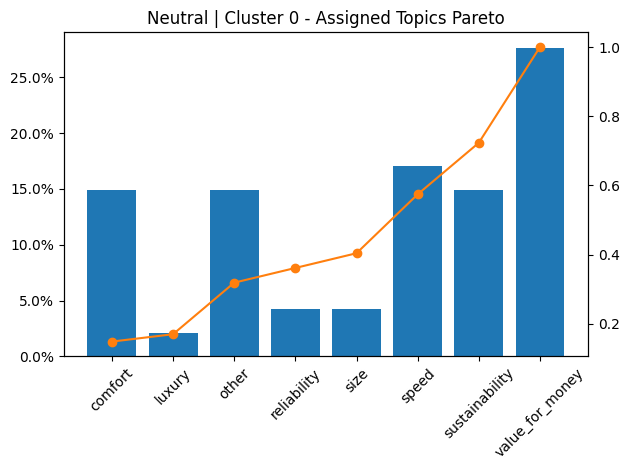

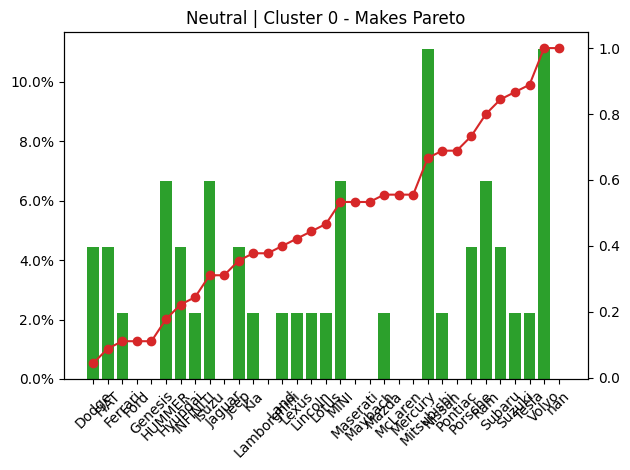

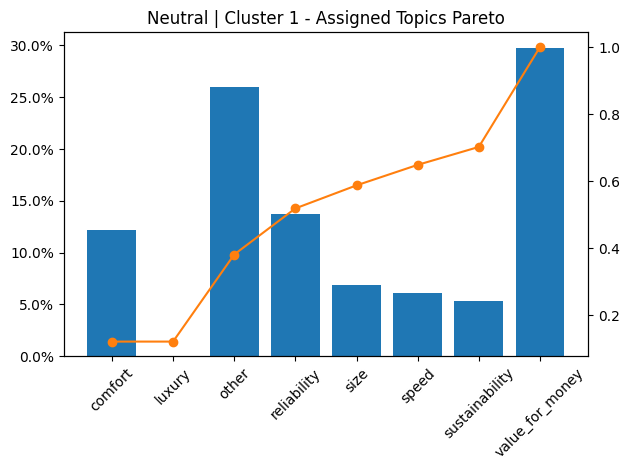

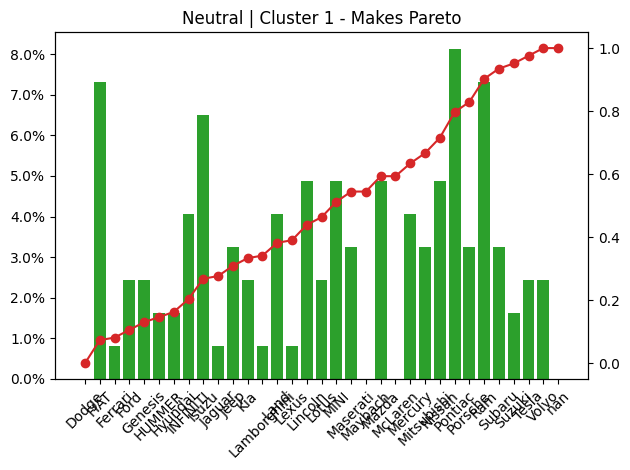

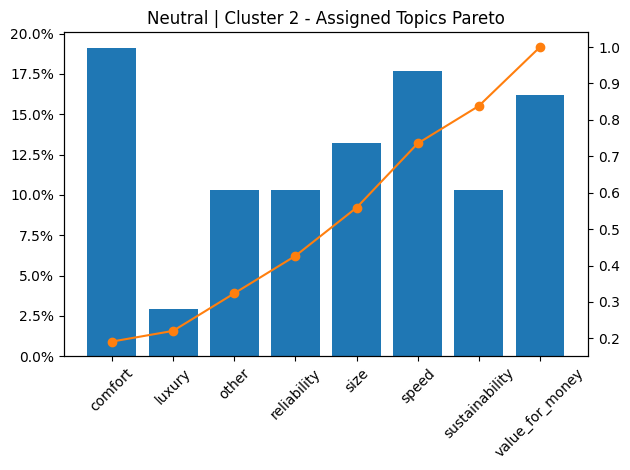

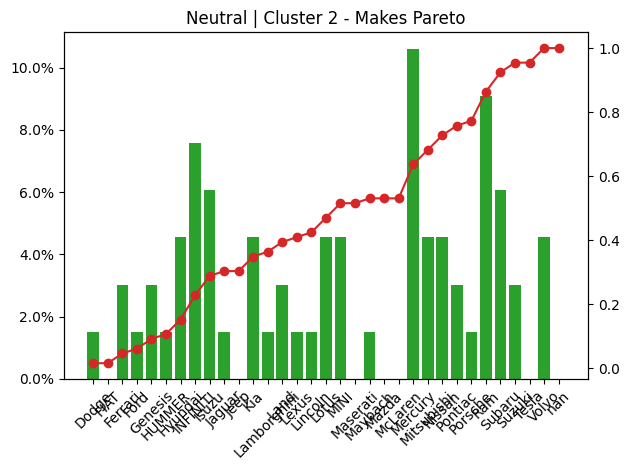

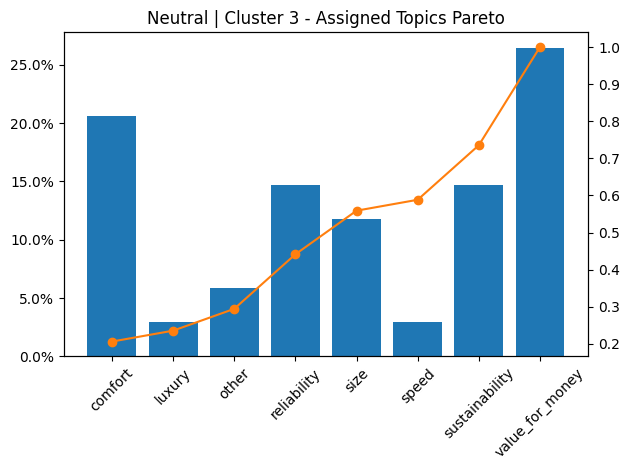

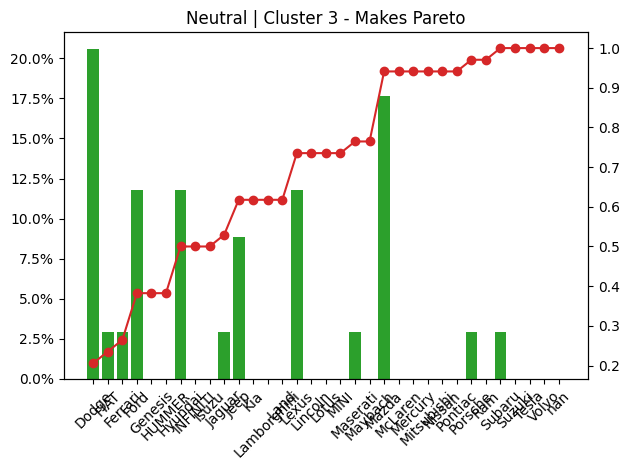

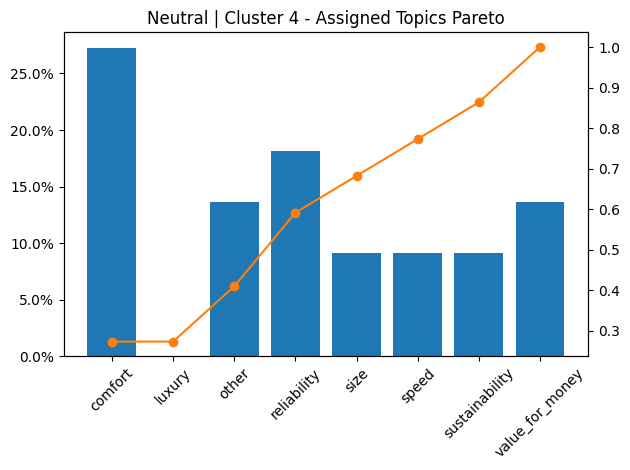

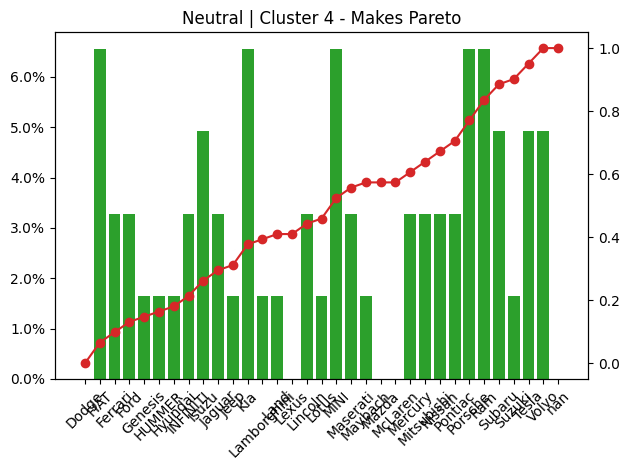

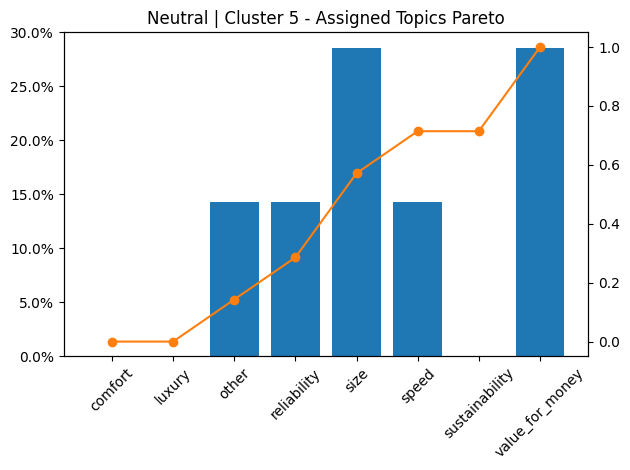

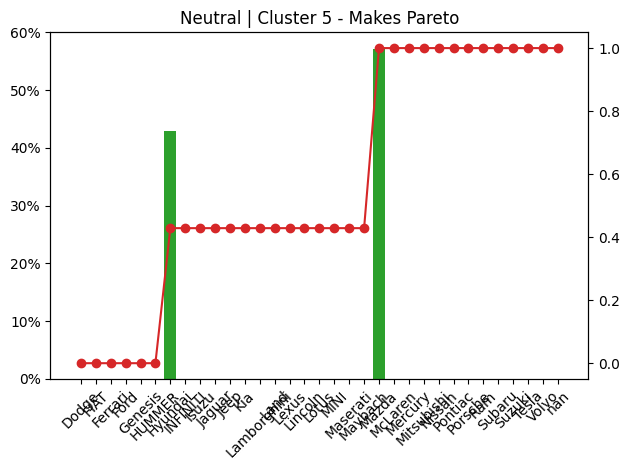

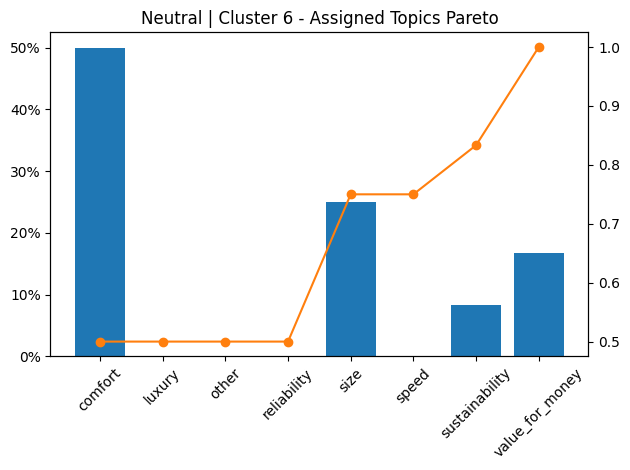

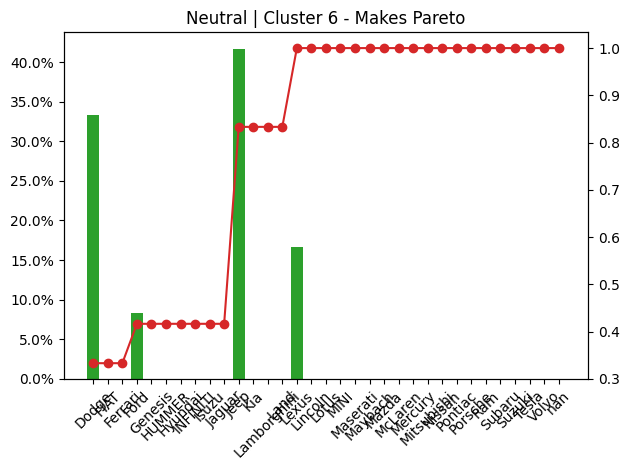

Breakdown CSV saved to C:/Users/happy/Documents/ironhack/RoboReview/ai-reviewer/data/sentiment_cluster_breakdown.csv
MLflow run completed: 4ffc5f5827ee4d1a908e354c90eebda7
🏃 View run Sentiment_Cluster_AssignedTopic_And_Make_Pareto at: http://127.0.0.1:5000/#/experiments/694015350079568292/runs/4ffc5f5827ee4d1a908e354c90eebda7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/694015350079568292


In [83]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import mlflow

# Load clustering output
df = pd.read_csv(r"C:/Users/happy/Documents/ironhack/RoboReview/ai-reviewer/data/enriched_with_clusters5.csv")

# Derive cluster_label from last word of text_for_clustering
df['cluster_label'] = df['text_for_clustering'].str.split().str[-1]

# Ensure required columns
to_check = ['sentiment', 'cluster', 'assigned_topic', 'make']
for col in to_check:
    if col not in df.columns:
        raise ValueError(f"Missing '{col}' column.")

# Unique values
sentiments = df['sentiment'].unique().tolist()
clusters = sorted(df['cluster'].unique().tolist())
assigned_topics = sorted(df['assigned_topic'].astype(str).unique().tolist())
makes = sorted(df['make'].astype(str).unique().tolist())

# Prepare CSV output list
records = []

# Start MLflow run
mlflow.set_experiment("cluster_sentiment_analysis")
with mlflow.start_run(run_name="Sentiment_Cluster_AssignedTopic_And_Make_Pareto"):
    for sentiment in sentiments:
        for cluster in clusters:
            sub = df[(df['sentiment']==sentiment)&(df['cluster']==cluster)]
            if sub.empty:
                continue
            # Assigned topic distribution
            topic_counts = sub['assigned_topic'].value_counts(normalize=True).reindex(assigned_topics, fill_value=0)
            # Make distribution
            make_counts = sub['make'].value_counts(normalize=True).reindex(makes, fill_value=0)

            # Record for CSV
            for topic, pct in topic_counts.items():
                records.append({
                    'sentiment': sentiment,
                    'cluster': cluster,
                    'type': 'assigned_topic',
                    'category': topic,
                    'percent': pct
                })
            for make, pct in make_counts.items():
                records.append({
                    'sentiment': sentiment,
                    'cluster': cluster,
                    'type': 'make',
                    'category': make,
                    'percent': pct
                })

            # Pareto plot for assigned_topic
            fig, ax = plt.subplots()
            ax.bar(assigned_topics, topic_counts.values, label='Percent', color='C0')
            ax2 = ax.twinx()
            ax2.plot(assigned_topics, topic_counts.cumsum().values, '-o', color='C1', label='Cumulative')
            ax.yaxis.set_major_formatter(PercentFormatter(1))
            ax.set_title(f"{sentiment.title()} | Cluster {cluster} - Assigned Topics Pareto")
            ax.tick_params(axis='x', labelrotation=45)
            plt.tight_layout()
            plt.show()
            fname = f"pareto_topic_{sentiment}_{cluster}.png"
            fig.savefig(fname)
            mlflow.log_artifact(fname)
            plt.close(fig)

            # Pareto plot for make
            fig, ax = plt.subplots()
            ax.bar(makes, make_counts.values, label='Percent', color='C2')
            ax2 = ax.twinx()
            ax2.plot(makes, make_counts.cumsum().values, '-o', color='C3', label='Cumulative')
            ax.yaxis.set_major_formatter(PercentFormatter(1))
            ax.set_title(f"{sentiment.title()} | Cluster {cluster} - Makes Pareto")
            ax.tick_params(axis='x', labelrotation=45)
            plt.tight_layout()
            plt.show()
            fname = f"pareto_make_{sentiment}_{cluster}.png"
            fig.savefig(fname)
            mlflow.log_artifact(fname)
            plt.close(fig)

    # Save CSV of records
    out_df = pd.DataFrame(records)
    csv_path = r"C:/Users/happy/Documents/ironhack/RoboReview/ai-reviewer/data/sentiment_cluster_breakdown.csv"
    out_df.to_csv(csv_path, index=False)
    mlflow.log_artifact(csv_path)
    print(f"Breakdown CSV saved to {csv_path}")
    print(f"MLflow run completed: {mlflow.active_run().info.run_id}")


In [84]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import mlflow

# Paths
enriched_path = r"C:/Users/happy/Documents/ironhack/RoboReview/ai-reviewer/data/enriched_with_clusters5.csv"
breakdown_path = r"C:/Users/happy/Documents/ironhack/RoboReview/ai-reviewer/data/sentiment_cluster_breakdown.csv"
deployment_path = r"C:/Users/happy/Documents/ironhack/RoboReview/ai-reviewer/data/enriched_with_clusters_deployment.csv"

# Load dataframes
df = pd.read_csv(enriched_path)
breakdown = pd.read_csv(breakdown_path)

# Derive cluster_label
if 'text_for_clustering' in df:
    df['cluster_label'] = df['text_for_clustering'].str.split().str[-1]
elif 'assigned_topic' in df:
    df['cluster_label'] = df['assigned_topic']
else:
    raise ValueError("Cannot derive cluster_label")

# Create multi-index keys for lookup
df['make_key'] = df['sentiment'].astype(str) + '_' + df['cluster'].astype(str) + '_' + df['make'].astype(str)
df['topic_key'] = df['sentiment'].astype(str) + '_' + df['cluster'].astype(str) + '_' + df['assigned_topic'].astype(str)

# In breakdown, define same keys
breakdown['key'] = breakdown['sentiment'].astype(str) + '_' + breakdown['cluster'].astype(str) + '_' + breakdown['category'].astype(str)

# Pivot breakdown to dicts for fast lookup
make_perc = breakdown[breakdown['type']=='make'].set_index('key')['percent'].to_dict()
topic_perc = breakdown[breakdown['type']=='assigned_topic'].set_index('key')['percent'].to_dict()

# Map percentages to original df
df['make_cluster_perc'] = df['make_key'].map(make_perc).fillna(0)
df['assigned_topic_cluster_perc'] = df['topic_key'].map(topic_perc).fillna(0)

# Save deployment CSV
df.to_csv(deployment_path, index=False)
print(f"Deployment file saved: {deployment_path}")


Deployment file saved: C:/Users/happy/Documents/ironhack/RoboReview/ai-reviewer/data/enriched_with_clusters_deployment.csv


In [ ]:
# Build a deployment app for top 3 recommendation. 
# Use streamlit and gpt-3.5-turbo. 
# The user could use multiselection to choose between the unique values of assigned_topic column. 
# User could also choose from multiselection of the unique values from the make column. 
import os
import pandas as pd
import mlflow
from openai import OpenAI
import streamlit as st
import base64

# --- Background Setup ---
def set_background(image_path):
    if os.path.exists(image_path):
        with open(image_path, "rb") as img_file:
            encoded = base64.b64encode(img_file.read()).decode()
        st.markdown(
            f"""
            <style>
            .stApp {{
                background-image: url(data:image/jpeg;base64,{encoded});
                background-size: cover;
                background-position: center;
                background-repeat: no-repeat;
                background-attachment: fixed;
            }}
            </style>
            """,
            unsafe_allow_html=True
        )

# Header
st.markdown(
    """
    <div style="
        font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
        background-color: rgba(255, 215, 0, 0.75);
        padding: 15px;
        border-radius: 5px;
        text-align: center;
        font-size: 28px;
        font-weight: bold;
        color: #fff;
        box-shadow: 0 4px 8px rgba(0,0,0,0.3);
        margin-bottom: 20px;">
        Happy to recommend...
    </div>
    """,
    unsafe_allow_html=True
)
background_path = r"C:/Users/happy/Documents/ironhack/RoboReview/ai-reviewer/Background.jpg"
set_background(background_path)

# --- Load deployment data ---
DATA_CSV = r"C:/Users/happy/Documents/ironhack/RoboReview/ai-reviewer/data/enriched_with_clusters_deployment.csv"
df = pd.read_csv(DATA_CSV)

# Verify required columns
required = ['make','model','assigned_topic','make_cluster_perc','assigned_topic_cluster_perc',
            'sentiment','sentiment_score','cluster','vehicle_title','review','text_for_clustering','strengths','weaknesses']
missing = [c for c in required if c not in df.columns]
if missing:
    st.error(f"Missing columns: {', '.join(missing)}")
    st.stop()

# --- OpenAI client ---
API_KEY = os.getenv('OPENAI_API_KEY')
if not API_KEY:
    st.error('Set OPENAI_API_KEY environment variable')
    st.stop()
client = OpenAI(api_key=API_KEY)

# --- UI Controls ---
# Safely generate make options as strings
top_make = sorted(df['make'].dropna().astype(str).unique().tolist())
# Assigned topics as strings, exclude 'other'
topics = sorted([t for t in df['assigned_topic'].dropna().astype(str).unique().tolist() if t.lower()!='other'])

# Styled headings for filters
st.markdown(
    """
    <style>
    .filter-label {
        font-weight: bold;
        color: white;
        font-size: 16px;
    }
    </style>
    """, unsafe_allow_html=True
)

# Multi-select for characteristics
st.markdown('<div class="filter-label">Choose your "car"acteristics:</div>', unsafe_allow_html=True)
selected_topic = st.multiselect('', topics)
# Multi-select for makes
st.markdown('<div class="filter-label">Narrow your car choices?</div>', unsafe_allow_html=True)
selected_makes = st.multiselect('', top_make)

# --- Filter data ---
filtered = df.copy()
# Cast to str for safe comparison
df_make = filtered['make'].astype(str)
df_topic = filtered['assigned_topic'].astype(str)
if selected_makes:
    filtered = filtered[df_make.isin(selected_makes)]
if selected_topic:
    filtered = filtered[df_topic.isin(selected_topic)]

# Keep only positive sentiment
filtered = filtered[filtered['sentiment']=='positive']

# Rank by combined metrics
filtered['rank_score'] = (
    0.4*filtered['make_cluster_perc'] +
    0.4*filtered['assigned_topic_cluster_perc'] +
    0.2*filtered['sentiment_score']
)
# Unique make-model
filtered = filtered.drop_duplicates(subset=['make','model'])

top3 = filtered.nlargest(3, 'rank_score')

# --- Few-shot examples ---
FEW_SHOT = [
    ("2025 Mercedes SL: Smooth ride, powerful V8...", "The 2025 Mercedes-Benz SL remains a benchmark..."),
    ("2025 Toyota Camry: Reliable sedan...", "The 2025 Toyota Camry delivers class-leading reliability...")
]

# --- Recommendation Display ---
if st.button('Recommend'):
    if top3.empty:
        st.warning('No recommendations found.')
    else:
        for _, car in top3.iterrows():
            title = car['vehicle_title']
            stars = '⭐' * int(round(car['rating']))
            # Build prompt
            messages = [
                {'role':'system','content':'You are a friendly automotive reviewer.'},
                {'role':'user','content':
                    f"Write a friendly, step-by-step review of {title}, highlighting {car['text_for_clustering']}. "
                    f"Mention its strengths ({car['strengths']}) and cons ({car['weaknesses']}). "
                    f"Note the rating ({car['rating']}/5) and sentiment score ({car['sentiment_score']:.2f})."
                    f"Assume that the reader has not purchased his or her vehicle yet and you help him/her decide."
                }
            ]
            resp = client.chat.completions.create(
                model='gpt-3.5-turbo',
                messages=messages,
                temperature=0.7
            )
            summary = resp.choices[0].message.content.strip()
            # Display
            st.markdown(
                f"<div style='background-color:rgba(255,255,255,0.9);padding:15px;border-radius:10px;margin-bottom:15px;'>"
                f"<h3>{title} {stars}</h3>"
                f"<p>{summary}</p>"
                f"<p><a href=\"https://www.edmunds.com/{car['make'].lower()}/\" target='_blank'>&#128279; More info</a></p>"
                f"</div>", unsafe_allow_html=True
            )

